# Vertification of UMM with Tilt

In [40]:
import analysis_utils as au
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import quick_metadata_plots as mplts
import analysis_utils as au
import padeopsIO as pio
import pandas as pd
import seaborn as sns
import streamtube
import itertools

In [41]:
from UnifiedMomentumModel.Momentum import UnifiedMomentum
from UnifiedMomentumModel.Utilities.Geometry import calc_eff_yaw

In [42]:
linewidth = 3.5
palette =['tab:orange', 'tab:green', 'tab:blue', 'tab:purple']

## UMM Results

### Get UMM Data

In [43]:
n_ct = 3
n_angles = 10
def get_umm_df(n_ct, n_angles):
    n_angles_sqrd = n_angles**2
    ctprimes = [0] * n_angles_sqrd * n_ct
    yaws = [0] * n_angles_sqrd * n_ct
    tilts = [0] * n_angles_sqrd * n_ct
    eff_angles = [0] * n_angles_sqrd * n_ct
    cps = [0] * n_angles_sqrd * n_ct
    ans = [0] * n_angles_sqrd * n_ct
    du4s = [0] * n_angles_sqrd * n_ct
    dv4s = [0] * n_angles_sqrd * n_ct
    dw4s = [0] * n_angles_sqrd * n_ct
    model = UnifiedMomentum()
    ct_yaw_tilt_combos = itertools.product((1, 1.33, 4), np.linspace(0, 30, num = n_angles), np.linspace(0, 30, num = n_angles))
    for (i, (ctp, y, t)) in enumerate(ct_yaw_tilt_combos):
        ctprimes[i] = ctp
        yaws[i] = y
        tilts[i] = t
        y_rad, t_rad = np.deg2rad(y), np.deg2rad(t)
        eff_angles[i] = np.rad2deg(calc_eff_yaw(y_rad, t_rad))
        sol = model(Ctprime = ctp, yaw = y_rad, tilt = t_rad)
        cps[i] = sol.Cp
        ans[i] = sol.an
        du4s[i] = 1 - sol.u4
        dv4s[i] = 0 - sol.v4
        dw4s[i] = 0 - sol.w4

    umm_data = {"Ctprime": ctprimes,
        "yaw": yaws,
        "tilt": tilts,
        "angle": eff_angles,
        "Cp": cps,
        "an": ans,
        "du4": du4s,
        "dv4": dv4s,
        "dw4": dw4s,
        }
    umm_df = pd.DataFrame(umm_data)
    umm_df = umm_df.sort_values(by=['Ctprime', 'angle', 'yaw'], ascending=True)
    return umm_df

In [44]:
umm_df = get_umm_df(n_ct, n_angles)
umm_df

,Ctprime,yaw,tilt,angle,Cp,an,du4,dv4,dw4
0,1.0,0.000000,0.000000,0.000000,0.512127,0.199934,0.391918,0.000000,0.000000
10,1.0,3.333333,0.000000,3.333333,0.510401,0.199479,0.390832,0.009284,0.000000
1,1.0,0.000000,3.333333,3.333333,0.510401,0.199479,0.390832,0.000000,-0.009284
11,1.0,3.333333,3.333333,4.712715,0.508679,0.199025,0.389748,0.009263,-0.009247
2,1.0,0.000000,6.666667,6.666667,0.505236,0.198117,0.387580,0.000000,-0.018411
...,...,...,...,...,...,...,...,...,...
279,4.0,23.333333,30.000000,37.325994,0.457858,0.389412,0.648440,0.093375,-0.108234
297,4.0,30.000000,23.333333,37.325994,0.457858,0.389412,0.648440,0.117875,-0.080866
289,4.0,26.666667,30.000000,39.293816,0.445819,0.378163,0.630926,0.103941,-0.103482
298,4.0,30.000000,26.666667,39.293816,0.445819,0.378163,0.630926,0.115799,-0.090015


In [45]:
limited_tilt_umm_df = umm_df[(umm_df["tilt"] % 10 == 0) & (umm_df["tilt"] <= 30)]
limited_yaw_umm_df = umm_df[(umm_df["yaw"] % 10 == 0) & (umm_df["yaw"] <= 30)]
limited_yaw_tilt_umm_df = limited_tilt_umm_df[(limited_tilt_umm_df["yaw"] % 10 == 0) & (limited_tilt_umm_df["yaw"] <= 30)]

### Plot UMM Data

#### By Yaw and Colored by Tilt

In [46]:
def cp_plots(limited_tilt_umm_df):
    cp_fig, (cp_ax0, cp_ax1, cp_ax2) = plt.subplots(1, 3, sharey = False, figsize = (12, 4), dpi = 300)
    cp_fig.suptitle("Mean $C_p$ vs Yaw ($\gamma$) by Tilt ($\phi$):", size = 16, y = 1.02)

    cp_ax0.set_title("C_T' = 1", size = 14)
    cp_ax0.set_ylabel('$C_P$', size = 14)
    cp_ax0.set_xlabel('Yaw ($\gamma$)', size = 14)
    cp_ax0.tick_params(axis='both', which='major', labelsize=12)
    cp_ax0.set_ylim(0, 1)

    cp_ax1.set_title("C_T' = 1.33", size = 14)
    cp_ax1.set_ylabel(' ')
    cp_ax1.set_xlabel('Yaw ($\gamma$)', size = 14)
    cp_ax1.tick_params(axis='both', which='major', labelsize=12)
    cp_ax1.set_ylim(0, 1)

    cp_ax2.set_title("C_T' = 4", size = 14)
    cp_ax2.set_ylabel(' ')
    cp_ax2.set_xlabel('Yaw ($\gamma$)', size = 14)
    cp_ax2.tick_params(axis='both', which='major', labelsize=12)
    cp_ax2.set_ylim(0, 1)

    sns.lineplot(ax = cp_ax0, data = limited_tilt_umm_df[limited_tilt_umm_df["Ctprime"] == 1],  x = "yaw", y = "Cp", hue = "tilt", linestyle = "dashed", linewidth = linewidth, palette = palette)
    sns.lineplot(ax = cp_ax1, data = limited_tilt_umm_df[limited_tilt_umm_df["Ctprime"] == 1.33],  x = "yaw", y = "Cp", hue = "tilt", linestyle = "dashed", linewidth = linewidth, palette = palette, legend = False)
    sns.lineplot(ax = cp_ax2, data = limited_tilt_umm_df[limited_tilt_umm_df["Ctprime"] == 4],  x = "yaw", y = "Cp", hue = "tilt", linestyle = "dashed", linewidth = linewidth, palette = palette, legend = False)

    leg = cp_ax0.legend(title='Tilt ($\phi$)')
    bb = leg.get_bbox_to_anchor().transformed(cp_ax0.transAxes.inverted())
    xOffset = 2.8
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg = leg.set_bbox_to_anchor(bb, transform = cp_ax0.transAxes)

    return cp_fig, (cp_ax0, cp_ax1, cp_ax2)

(<Figure size 3600x1200 with 3 Axes>,
 (<Axes: title={'center': "C_T' = 1"}, xlabel='Yaw ($\\gamma$)', ylabel='$C_P$'>,
  <Axes: title={'center': "C_T' = 1.33"}, xlabel='Yaw ($\\gamma$)', ylabel=' '>,
  <Axes: title={'center': "C_T' = 4"}, xlabel='Yaw ($\\gamma$)', ylabel=' '>))

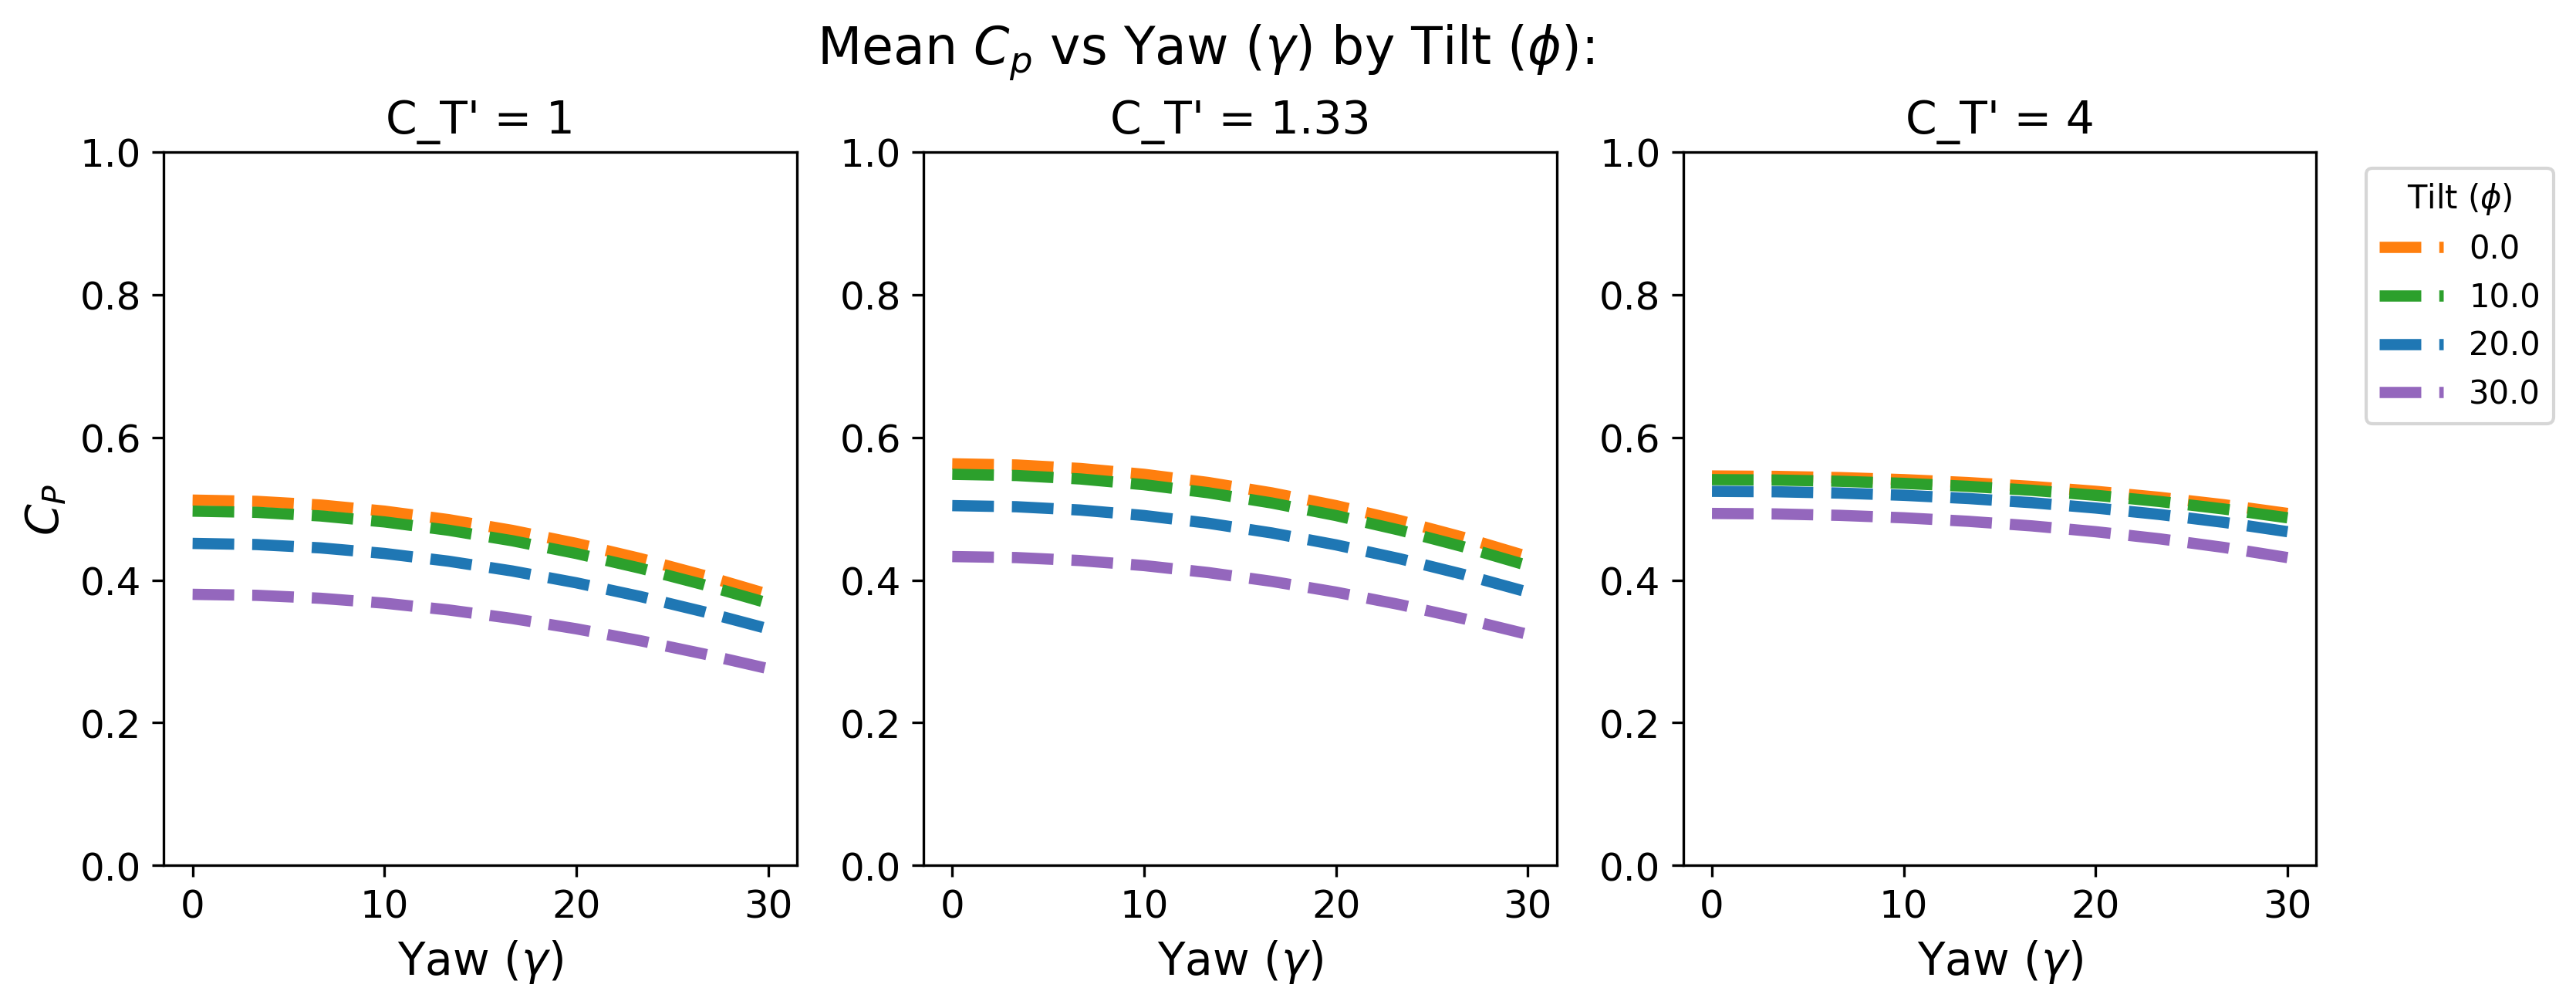

In [47]:
cp_plots(limited_tilt_umm_df)

In [48]:
def plot_vels(limited_tilt_umm_df, ctprime = [1, 1.33, 4]):

    vels_fig0, axes0 = plt.subplots(1, 3, dpi = 300, sharey = True, figsize = (8, 4))
    vels_fig0.suptitle(f"$\delta u_4$ vs Yaw ($\gamma$) by Tilt ($\phi$)", size = 16, y = 1.04)
    for i, ax in enumerate(axes0):
        ctp = ctprime[i]
        ax.set_title(f"$C_T' = {ctp}$", size = 16)
        ax.set_xlabel('Yaw ($\\gamma$)', size = 16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        add_legend = True if i == 0 else False
        sns.lineplot(ax = ax, data = limited_tilt_umm_df[limited_tilt_umm_df["Ctprime"] == ctp],  x = "yaw", y = "du4", hue = "tilt", linestyle = "dashed", linewidth = linewidth, palette = palette, legend = add_legend)
        if add_legend:
            ax.set_ylabel('$\\delta u_4$', size = 16)
            ax.legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)
        else:
            ax.set_ylabel(' ')
    vels_fig0.subplots_adjust(wspace=0.25)

    vels_fig1, axes1 = plt.subplots(1, 3, dpi = 300, sharey = True, figsize = (8, 4))
    vels_fig1.suptitle(f"$\delta v_4$ vs Yaw ($\gamma$) by Tilt ($\phi$)", size = 16, y = 1.04)
    for i, ax in enumerate(axes1):
        ctp = ctprime[i]
        ax.set_title(f"$C_T' = {ctp}$", size = 16)
        ax.set_xlabel('Yaw ($\\gamma$)', size = 16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        add_legend = True if i == 0 else False
        sns.lineplot(ax = ax, data = limited_tilt_umm_df[limited_tilt_umm_df["Ctprime"] == ctp],  x = "yaw", y = "dv4", hue = "tilt", linestyle = "dashed", linewidth = linewidth, palette = palette, legend = add_legend)
        if add_legend:
            ax.set_ylabel('$\\delta v_4$', size = 16)
            ax.legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)
        else:
            ax.set_ylabel(' ')
    vels_fig1.subplots_adjust(wspace=0.25)

    vels_fig2, axes2 = plt.subplots(1, 3, dpi = 300, sharey = True, figsize = (8, 4))
    vels_fig2.suptitle(f"$\delta w_4$ vs Yaw ($\gamma$) by Tilt ($\phi$)", size = 16, y = 1.04)
    for i, ax in enumerate(axes2):
        ctp = ctprime[i]
        ax.set_title(f"$C_T' = {ctp}$", size = 16)
        ax.set_xlabel('Yaw ($\\gamma$)', size = 16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        add_legend = True if i == 0 else False
        sns.lineplot(ax = ax, data = limited_tilt_umm_df[limited_tilt_umm_df["Ctprime"] == ctp],  x = "yaw", y = "dw4", hue = "tilt", linestyle = "dashed", linewidth = linewidth, palette = palette, legend = add_legend)
        if add_legend:
            ax.set_ylabel('$\\delta w_4$', size = 16)
            ax.legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)
        else:
            ax.set_ylabel(' ')
    vels_fig2.subplots_adjust(wspace=0.25)

    return (vels_fig0, axes0), (vels_fig1, axes1), (vels_fig2, axes2)


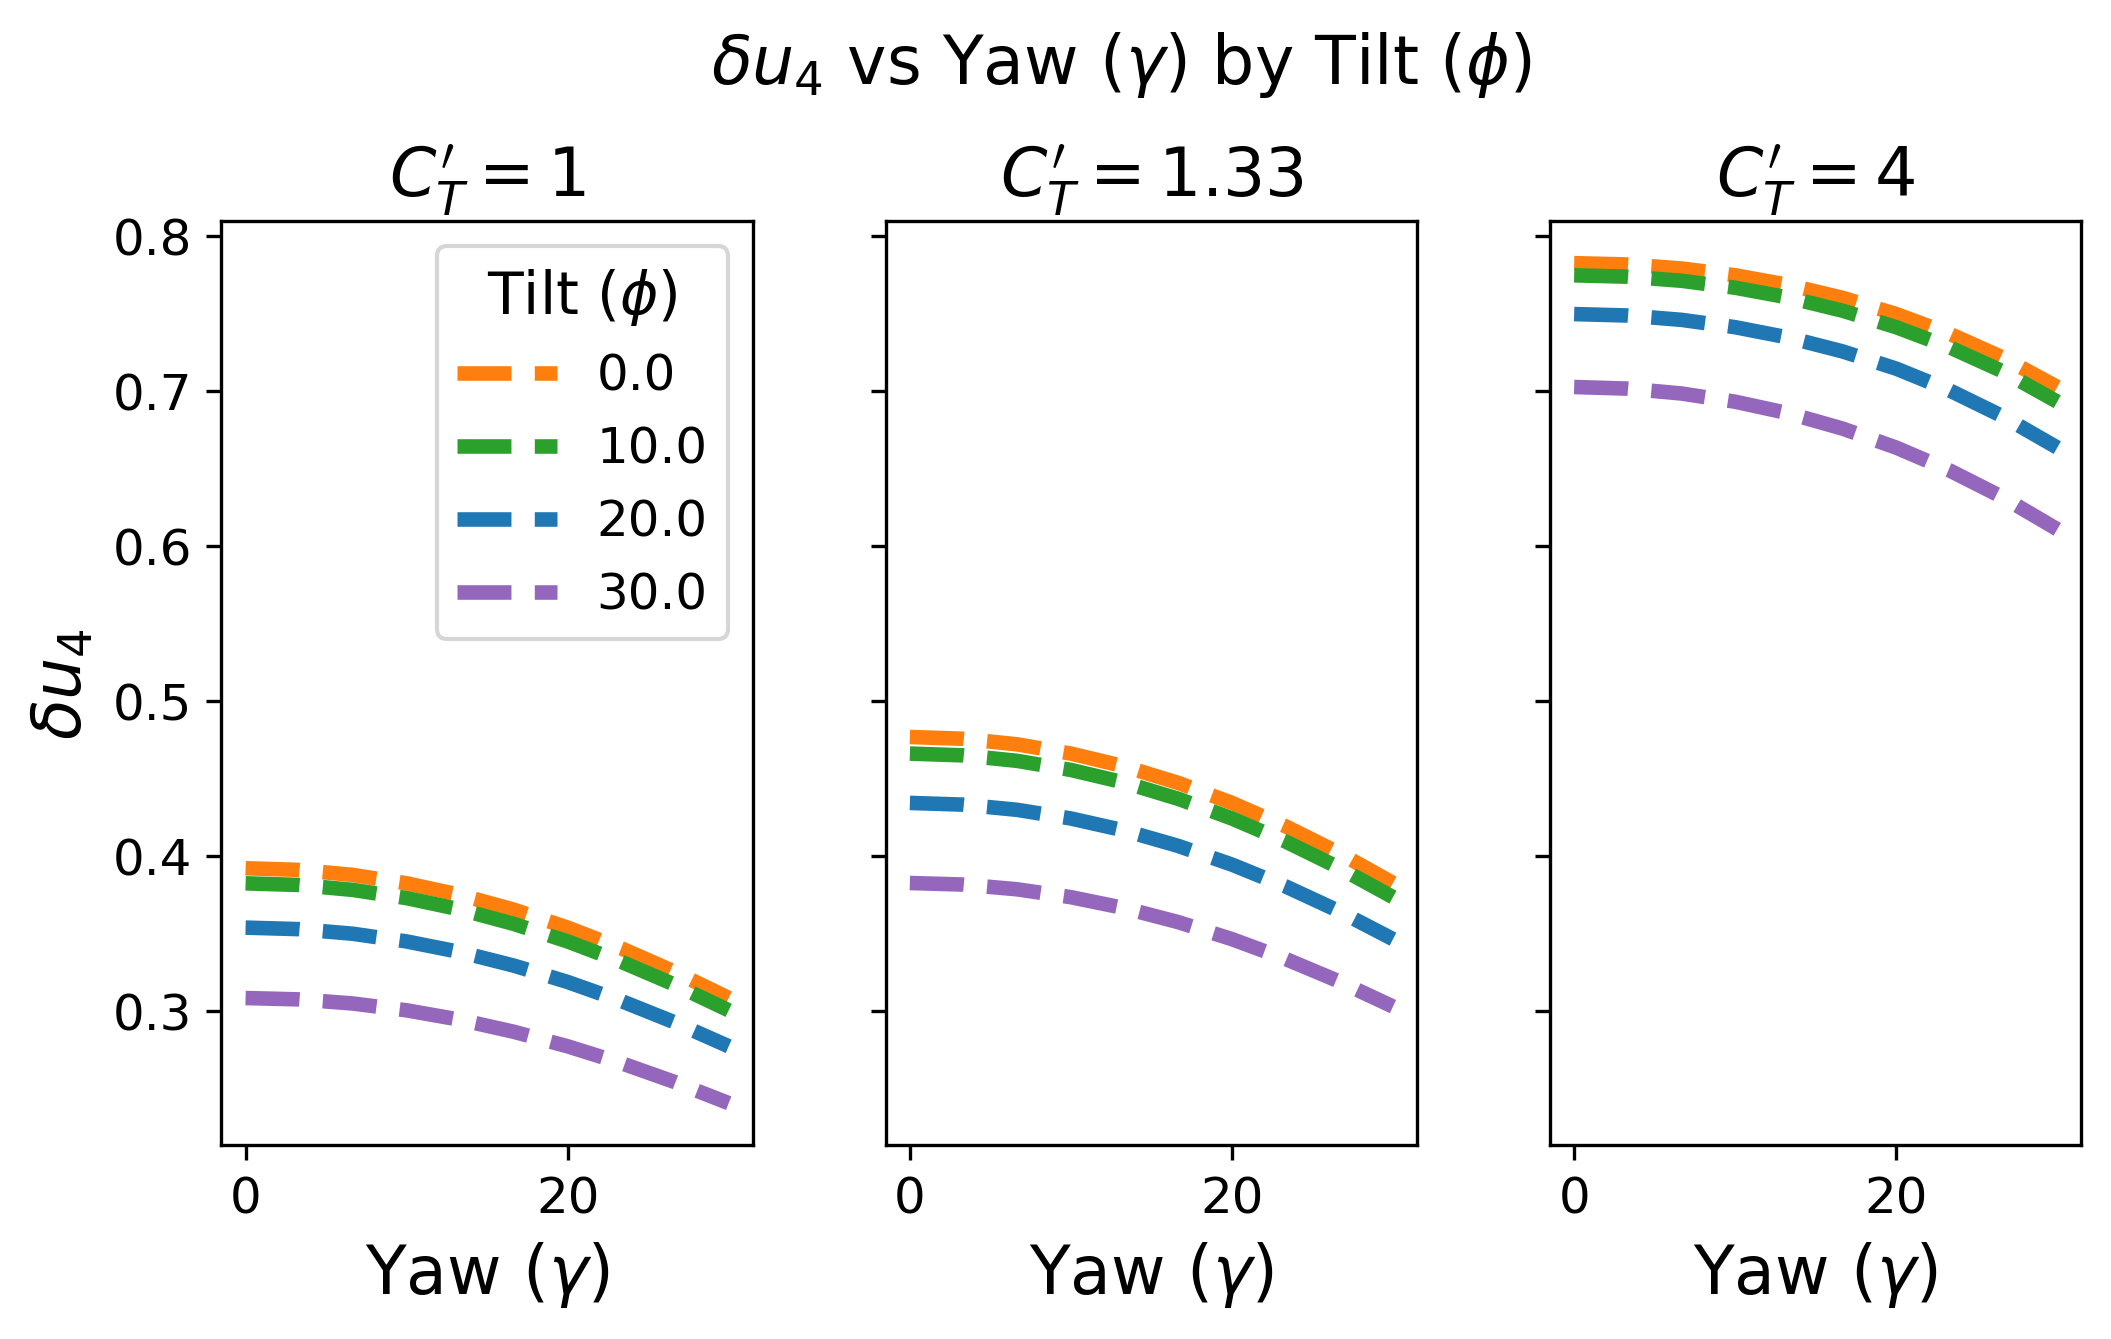

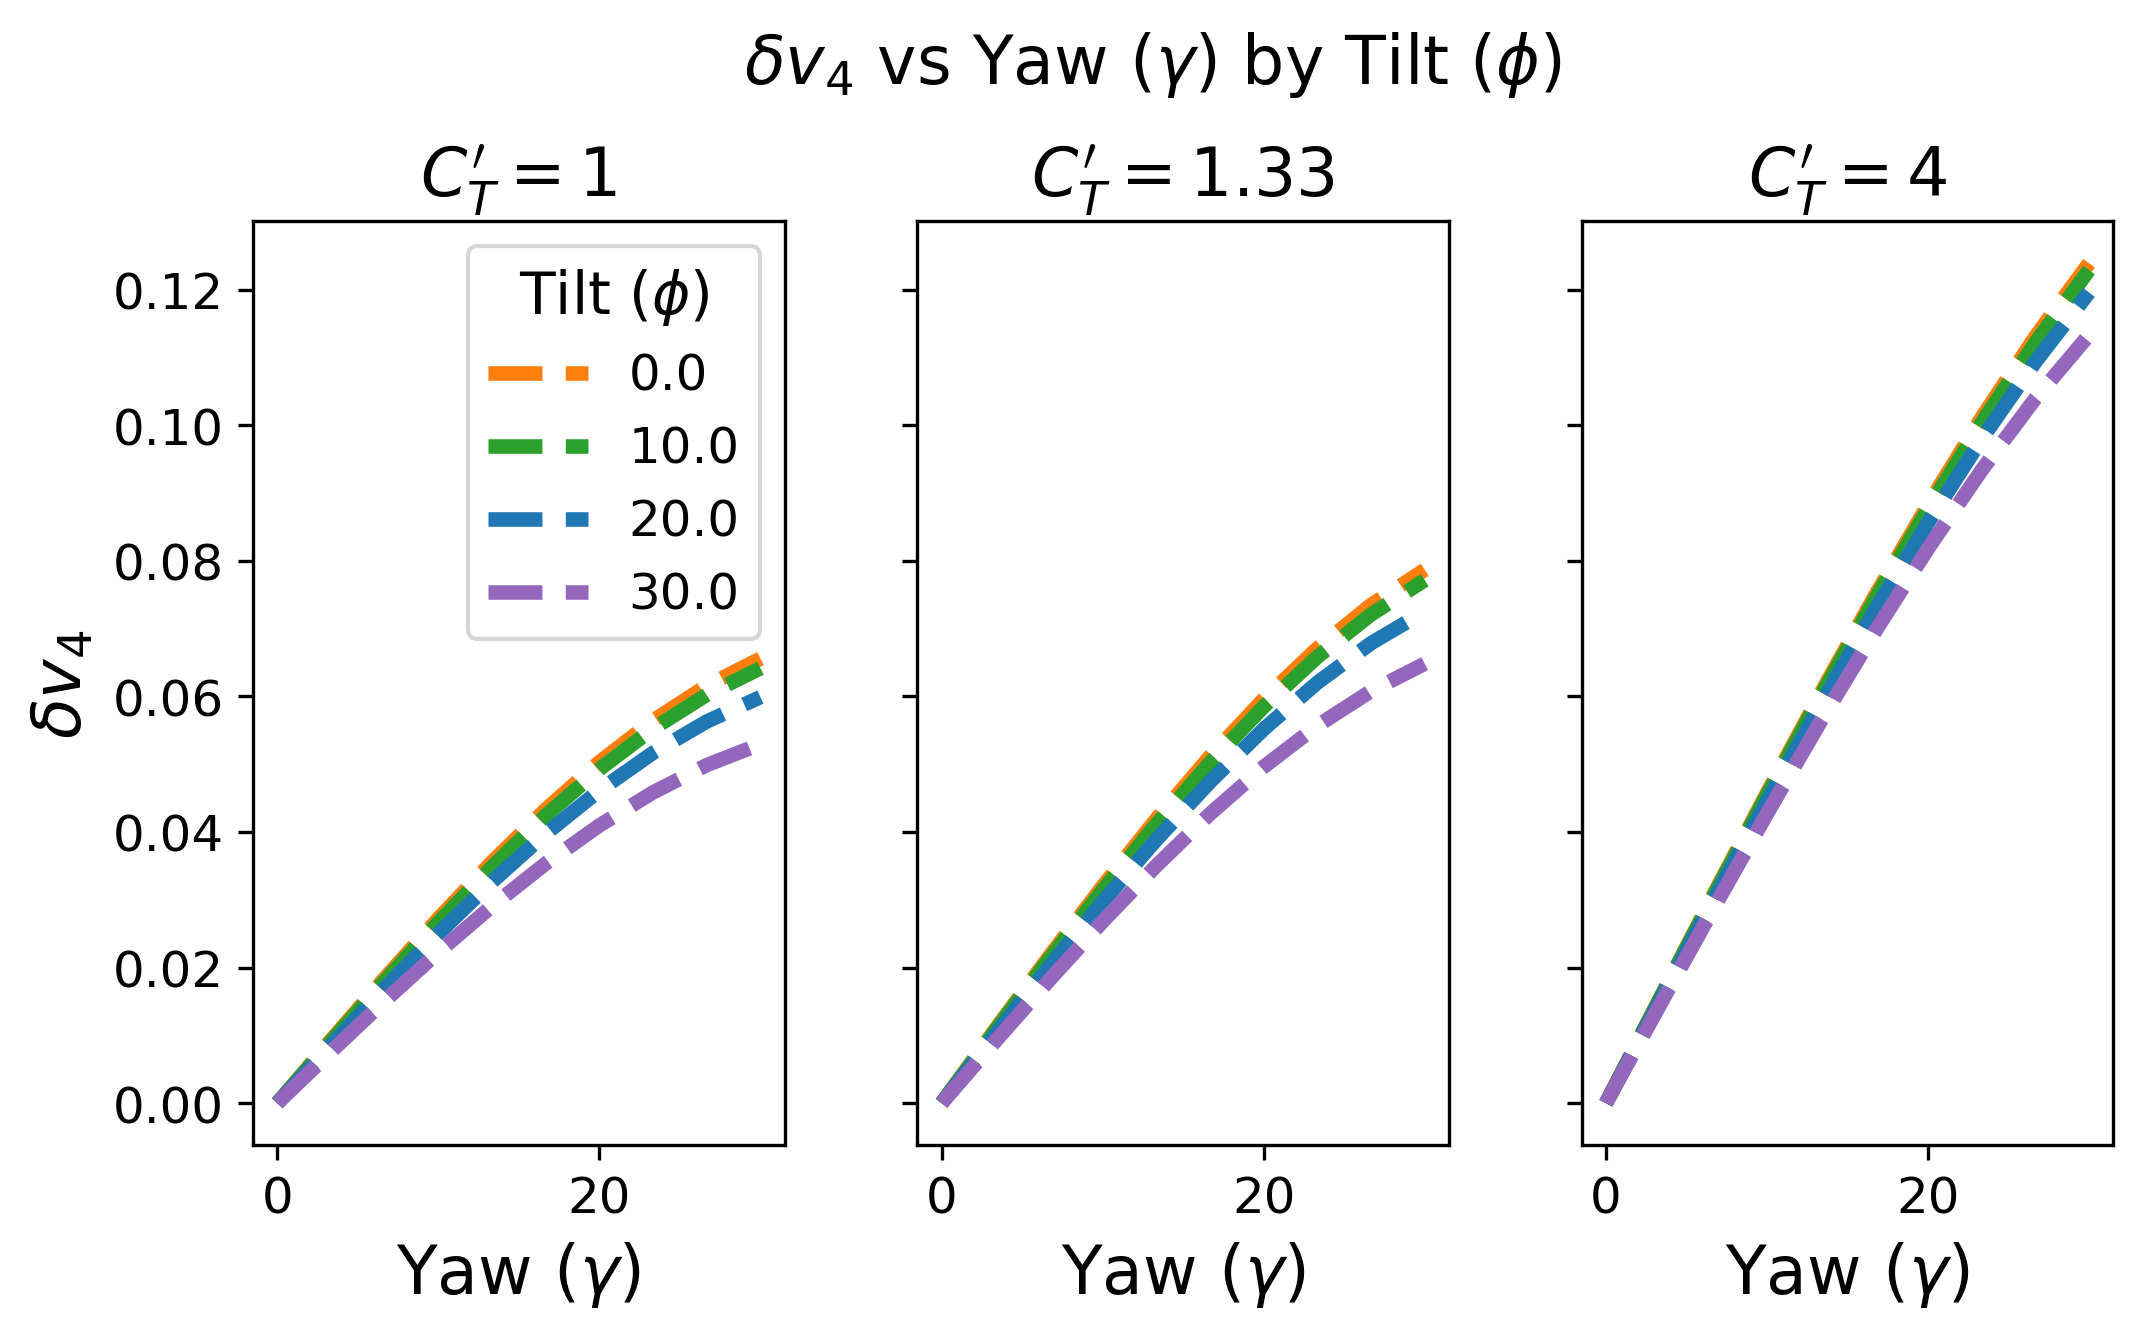

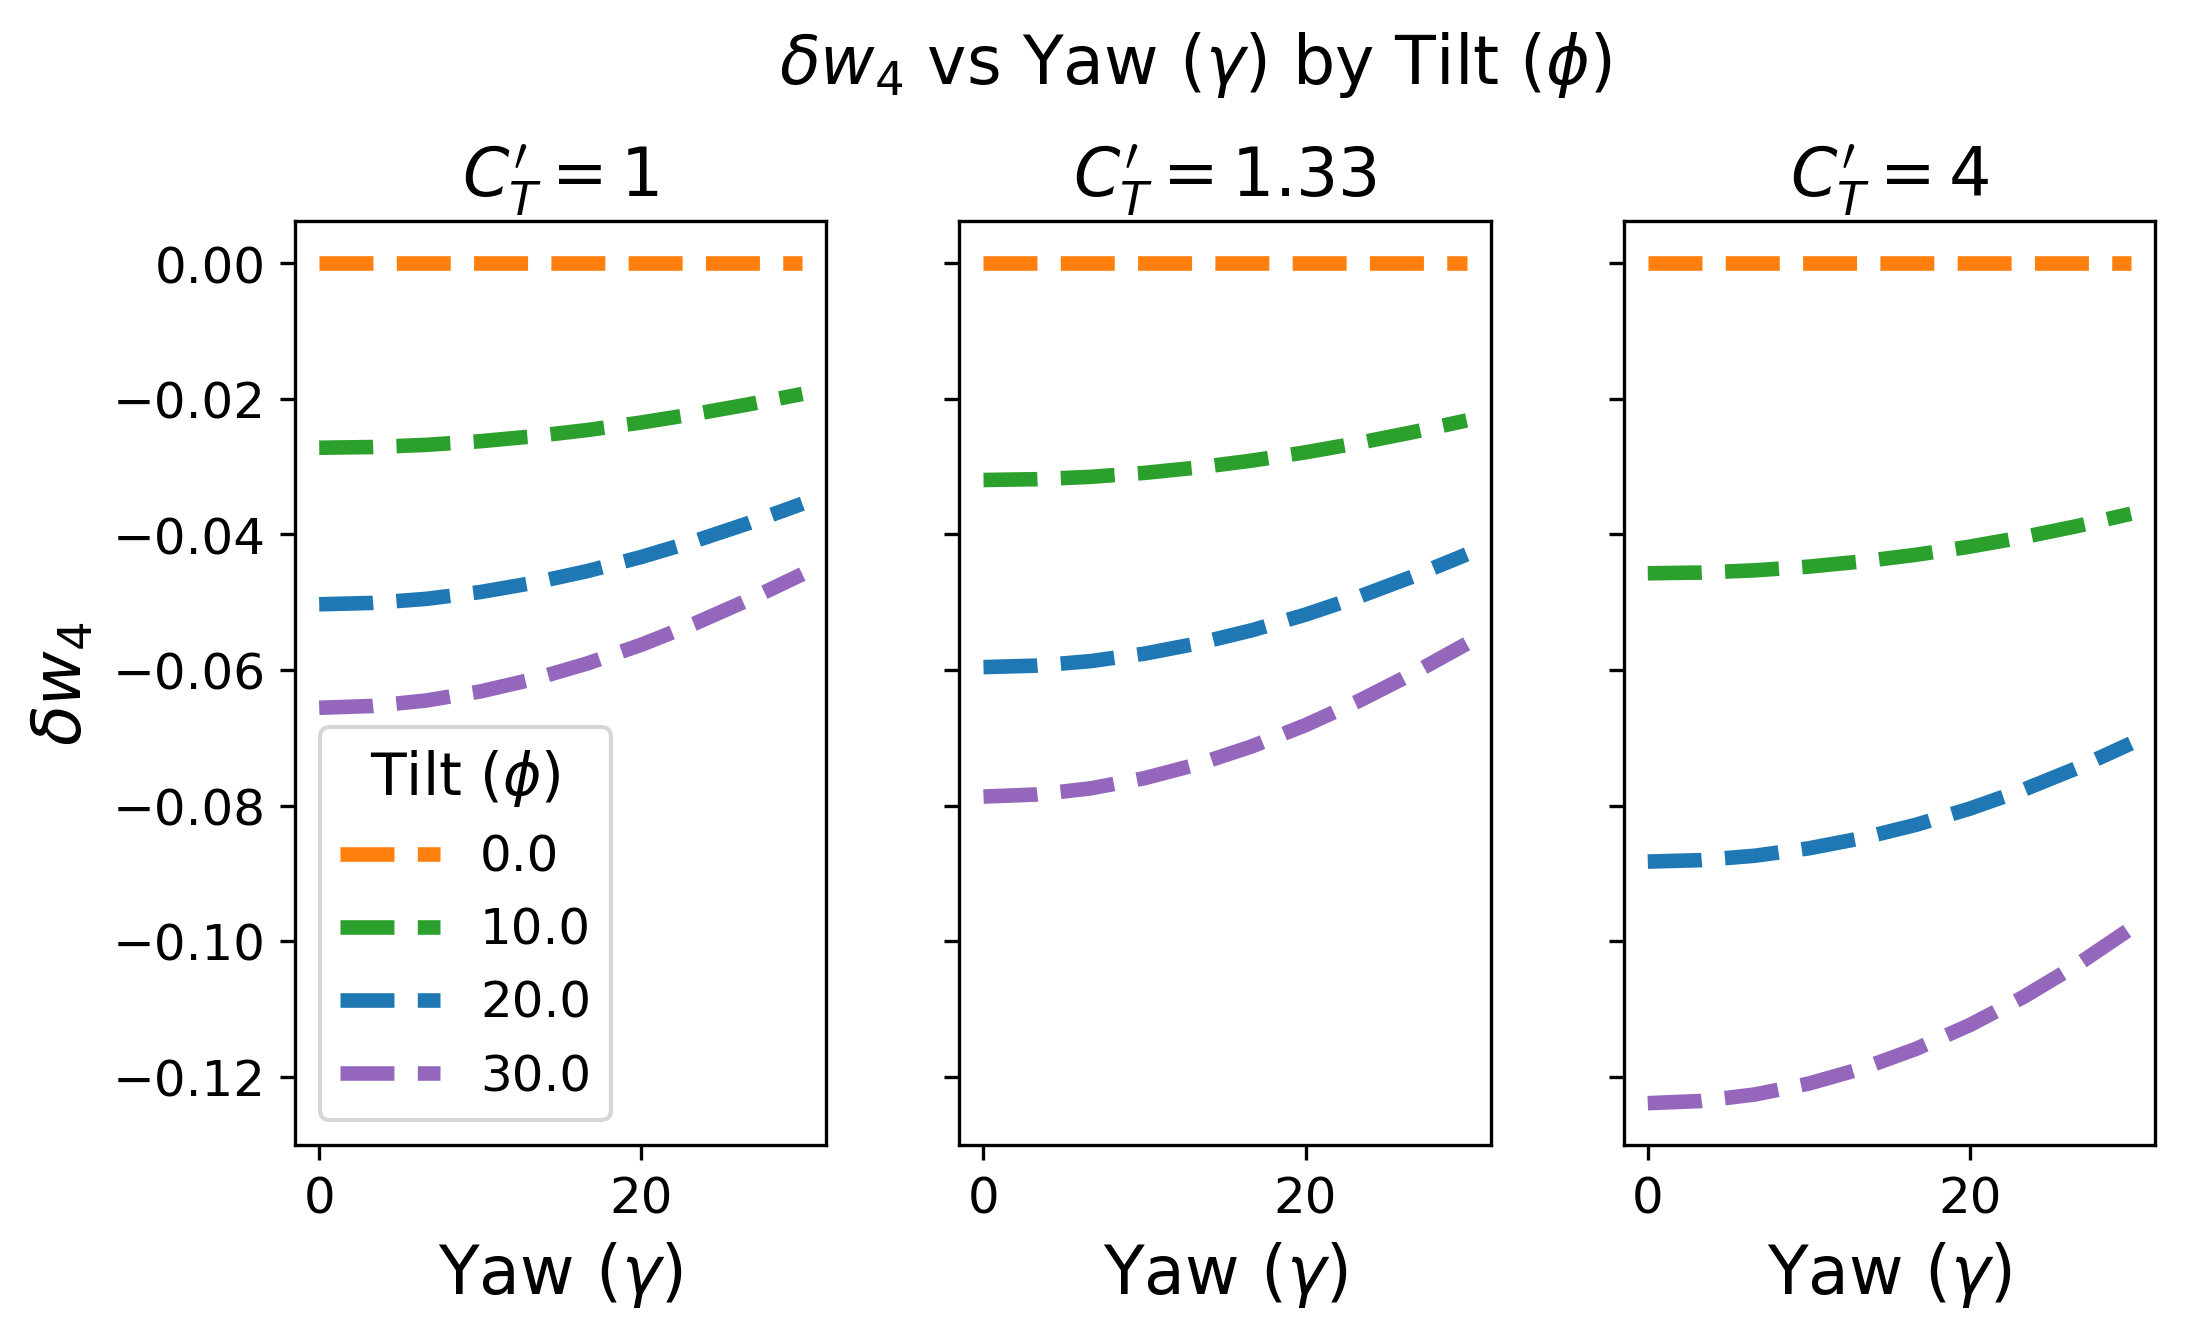

In [49]:
(vels_fig0, vels_ax0), (vels_fig1, vels_ax1), (vels_fig2, vels_ax2) = plot_vels(limited_tilt_umm_df)

## Get LES PadéOps Data

In [50]:
data_path = Path(au.DATA_PATH)
sim_folder = os.path.join(au.DATA_PATH, "B_0001_Files")
rows, fields = mplts.get_sim_varied_params(sim_folder)
les_ids, les_cT, les_budget, les_yaw, les_tilt, les_filterWidth = zip(*rows)

In [51]:
run_folder = au.get_run_folder(sim_folder, 48)
sim = pio.BudgetIO(run_folder, padeops = True, runid = 0, normalize_origin="turbine")

In [52]:
ds = sim.slice(field_terms=["u", "v", "w", "x", "y", "z"], xlim = [-5, 20], ylim = [-2.5, 2.5], zlim = [-2.5, 2.5])
ds.u

BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5037, time: 250.036867


<xarray.DataArray 'u' (x: 256, y: 65, z: 65)> Size: 9MB
array([[[0.99995365, 0.99993934, 0.99992483, ..., 0.99992687,
         0.99994135, 0.99995563],
        [0.99993944, 0.99992454, 0.99990944, ..., 0.99991167,
         0.99992671, 0.99994157],
        [0.99992505, 0.99990956, 0.99989385, ..., 0.99989629,
         0.9999119 , 0.99992734],
        ...,
        [0.99993388, 0.99991926, 0.99990446, ..., 0.99990355,
         0.99991834, 0.99993293],
        [0.99994786, 0.9999338 , 0.99991957, ..., 0.99991853,
         0.99993273, 0.99994679],
        [0.99996164, 0.99994813, 0.99993446, ..., 0.99993331,
         0.99994695, 0.99996048]],

       [[0.99995766, 0.99994205, 0.99992622, ..., 0.99992702,
         0.9999428 , 0.99995843],
        [0.99994218, 0.99992592, 0.99990946, ..., 0.99991037,
         0.99992681, 0.99994303],
        [0.9999265 , 0.9999096 , 0.99989248, ..., 0.99989354,
         0.99991061, 0.99992747],
...
        [0.99992786, 0.99991567, 0.99990334, ..., 0.99990481,
         0.99991707, 0.99992923],
        [0.99993952, 0.9999278 , 0.99991595, ..., 0.99991717,
         0.99992901, 0.9999407 ],
        [0.99995101, 0.99993976, 0.99992837, ..., 0.99992943,
         0.9999408 , 0.99995204]],

       [[0.99995053, 0.99993743, 0.99992418, ..., 0.99992709,
         0.99994031, 0.99995334],
        [0.99993751, 0.99992389, 0.99991008, ..., 0.99991322,
         0.99992694, 0.99994051],
        [0.99992434, 0.99991017, 0.99989579, ..., 0.99989915,
         0.99991343, 0.99992752],
        ...,
        [0.99993088, 0.99991753, 0.99990403, ..., 0.99990436,
         0.99991783, 0.99993114],
        [0.99994365, 0.99993082, 0.99991783, ..., 0.99991799,
         0.99993093, 0.99994377],
        [0.99995625, 0.99994392, 0.99993144, ..., 0.99993142,
         0.9999439 , 0.99995623]]], shape=(256, 65, 65))
Coordinates:
  * x        (x) float64 2kB -5.0 -4.902 -4.805 -4.707 ... 19.61 19.71 19.8 19.9
  * y        (y) float64 520B -2.5 -2.422 -2.344 -2.266 ... 2.344 2.422 2.5
  * z        (z) float64 520B -2.539 -2.461 -2.383 -2.305 ... 2.305 2.383 2.461

In [53]:
ds = sim.slice(budget_terms=["ubar", "vbar", "wbar"], xlim = [-5, 20], ylim = [-2.5, 2.5], zlim = [-2.5, 2.5])
ds.ubar

<xarray.DataArray 'ubar' (x: 256, y: 65, z: 65)> Size: 9MB
array([[[0.99996516, 0.99995135, 0.99993736, ..., 0.99992291,
         0.99993705, 0.99995104],
        [0.9999516 , 0.99993725, 0.9999227 , ..., 0.99990762,
         0.99992234, 0.99993689],
        [0.99993788, 0.99992297, 0.99990785, ..., 0.99989215,
         0.99990745, 0.99992257],
        ...,
        [0.99993801, 0.99992311, 0.99990799, ..., 0.99989215,
         0.99990745, 0.99992257],
        [0.99995173, 0.99993739, 0.99992285, ..., 0.99990763,
         0.99992234, 0.99993689],
        [0.99996529, 0.9999515 , 0.99993752, ..., 0.99992292,
         0.99993706, 0.99995104]],

       [[0.99996989, 0.9999548 , 0.99993951, ..., 0.99992372,
         0.99993918, 0.99995447],
        [0.99995506, 0.99993937, 0.99992347, ..., 0.99990701,
         0.9999231 , 0.99993901],
        [0.99994006, 0.99992376, 0.99990723, ..., 0.99989009,
         0.99990682, 0.99992335],
...
        [0.99993468, 0.99992227, 0.99990968, ..., 0.9998964 ,
         0.99990915, 0.99992174],
        [0.99994609, 0.99993415, 0.99992204, ..., 0.9999093 ,
         0.99992155, 0.99993367],
        [0.99995736, 0.99994589, 0.99993425, ..., 0.99992203,
         0.9999338 , 0.99994545]],

       [[0.99996094, 0.99994834, 0.99993556, ..., 0.99992234,
         0.99993526, 0.99994804],
        [0.99994857, 0.99993546, 0.99992217, ..., 0.99990838,
         0.99992183, 0.99993512],
        [0.99993605, 0.99992243, 0.99990862, ..., 0.99989425,
         0.99990822, 0.99992204],
        ...,
        [0.99993619, 0.99992258, 0.99990878, ..., 0.99989427,
         0.99990824, 0.99992205],
        [0.99994872, 0.99993562, 0.99992234, ..., 0.99990841,
         0.99992185, 0.99993513],
        [0.99996109, 0.9999485 , 0.99993573, ..., 0.99992237,
         0.99993528, 0.99994805]]], shape=(256, 65, 65))
Coordinates:
  * x        (x) float64 2kB -5.0 -4.902 -4.805 -4.707 ... 19.61 19.71 19.8 19.9
  * y        (y) float64 520B -2.5 -2.422 -2.344 -2.266 ... 2.344 2.422 2.5
  * z        (z) float64 520B -2.539 -2.461 -2.383 -2.305 ... 2.305 2.383 2.461

In [54]:
def get_wake_vels(sim, filterwidth, budget):
    if budget:
        ds_budget = sim.slice(budget_terms=["ubar", "vbar", "wbar"], xlim = [-5, 20], ylim = [-2.5, 2.5], zlim = [-2.5, 2.5])
        u, v, w = ds_budget.ubar, ds_budget.vbar, ds_budget.wbar
        ds_field = sim.slice(field_terms=["x", "y", "z"], xlim = [-5, 20], ylim = [-2.5, 2.5], zlim = [-2.5, 2.5])
        x, y, z = ds_field.x, ds_field.y, ds_field.z
    else:
        ds = sim.slice(field_terms=["u", "v", "w", "x", "y", "z"], xlim = [-5, 20], ylim = [-2.5, 2.5], zlim = [-2.5, 2.5])
        x, y, z, u, v, w = ds.x, ds.y, ds.z, ds.u, ds.v, ds.w
    stream = streamtube.Streamtube(x, y, z, u, v, w)
    stream.compute_streamtube(R = 0.3)  # D/2 - filterwidth
    stream.compute_mask(R = 0.5 - filterwidth)
    dumax, dvmax, dwmax = 0, 0, 0
    for i in range(stream.mask.shape[0]):
        mask = stream.mask[i, :, :]
        umean = np.average(u[i, :, :], weights = mask)
        vmean = np.average(v[i, :, :], weights = mask)
        wmean = np.average(w[i, :, :], weights = mask)
        dumax = (1 - umean) if np.abs(1 - umean) > np.abs(dumax) else dumax
        dvmax = (0 - vmean) if np.abs(0 - vmean) > np.abs(dvmax) else dvmax
        dwmax = (0 - wmean) if np.abs(0 - wmean) > np.abs(dwmax) else dwmax
    return dumax, dvmax, dwmax

In [55]:
def get_les_df(CT_vals, budget_vals, yaw_vals, tilt_vals, filterwidth_vals):
    nruns = len(yaw_vals)
    ctprimes = [0] * nruns
    budgets = [True] * nruns
    yaws = [0] * nruns
    tilts = [0] * nruns
    eff_angles = [0] * nruns
    cps = [0] * nruns
    du4s = [0] * nruns
    dv4s = [0] * nruns
    dw4s = [0] * nruns

    for i in range(0, nruns):
        run_folder = au.get_run_folder(sim_folder, i)
        sim = pio.BudgetIO(run_folder, padeops = True, runid = 0, normalize_origin="turbine")
        
        ctprimes[i] = float(CT_vals[i])
        yaws[i] = float(yaw_vals[i])
        tilts[i] = float(tilt_vals[i])
        y_rad, t_rad = np.deg2rad(yaws[i]), np.deg2rad(tilts[i])
        eff_angles[i] = np.rad2deg(calc_eff_yaw(y_rad, t_rad))

        mean_dt = sim.get_dt()
        power = sim.read_turb_power("all", turb=1)[round(100 / mean_dt):]
        avg_power = np.mean(power)
        cps[i] = au.power_to_Cp(avg_power)
        budgets[i] = True if budget_vals[i] == "True" else False
        dumax, dvmax, dwmax = get_wake_vels(sim, float(filterwidth_vals[i]), budgets[i])
        du4s[i], dv4s[i], dw4s[i] = dumax, dvmax, dwmax


    les_data = {"Ctprime": ctprimes,
        "budget": budgets,
        "yaw": yaws,
        "tilt": tilts,
        "angle": eff_angles,
        "Cp": cps,
        "du4": du4s,
        "dv4": dv4s,
        "dw4": dw4s,
        }
    les_df = pd.DataFrame(les_data)
    les_df = les_df.sort_values(by=['Ctprime', 'angle', 'yaw'], ascending=True)
    return les_df

In [56]:
les_df = get_les_df(les_cT, les_budget, les_yaw, les_tilt, les_filterWidth)
les_df

/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0000 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3758, time: 250.047130


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0001 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3771, time: 250.019092


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0002 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3974, time: 250.058463


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0003 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3972, time: 250.032357


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0004 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3775, time: 250.012316


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0005 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3941, time: 250.048204


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0006 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4031, time: 250.000897


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0007 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4115, time: 250.002036


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0008 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3915, time: 250.004064


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0009 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4049, time: 250.022180


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0010 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4206, time: 250.052265


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0011 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4153, time: 250.026497


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0012 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 3948, time: 250.034384


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0013 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4076, time: 250.030931


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0014 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4039, time: 250.027319


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0015 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 4006, time: 250.052655


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0016 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5062, time: 250.017421


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0017 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5235, time: 250.046442


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0018 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5334, time: 250.008880


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0019 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5280, time: 250.014392


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0020 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5250, time: 250.046490


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0021 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5338, time: 250.016198


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0022 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5392, time: 250.006770


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0023 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5342, time: 250.044447


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0024 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5160, time: 250.019376


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0025 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5244, time: 250.032070


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0026 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5559, time: 250.044329


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0027 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5200, time: 250.042772


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0028 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5254, time: 250.033654


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0029 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5401, time: 250.040904


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0030 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5207, time: 250.022989


/home1/10264/sgering/.cache/pypoetry/virtualenvs/simspadeops-YbNxeWqo-py3.11/lib/python3.11/site-packages/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0031 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")


BudgetIO loaded fields ['u', 'v', 'w'] at tidx: 5073, time: 250.038724
BudgetIO loaded fields [] at tidx: 3893, time: 250.031455
BudgetIO loaded fields [] at tidx: 4226, time: 250.038575
BudgetIO loaded fields [] at tidx: 4221, time: 250.052154
BudgetIO loaded fields [] at tidx: 4358, time: 250.011039
BudgetIO loaded fields [] at tidx: 4032, time: 250.029732
BudgetIO loaded fields [] at tidx: 4293, time: 250.048737
BudgetIO loaded fields [] at tidx: 4270, time: 250.000094
BudgetIO loaded fields [] at tidx: 4270, time: 250.037292
BudgetIO loaded fields [] at tidx: 4143, time: 250.008580
BudgetIO loaded fields [] at tidx: 4334, time: 250.017333
BudgetIO loaded fields [] at tidx: 4352, time: 250.044207
BudgetIO loaded fields [] at tidx: 4413, time: 250.014924
BudgetIO loaded fields [] at tidx: 4106, time: 250.002898
BudgetIO loaded fields [] at tidx: 4243, time: 250.025293
BudgetIO loaded fields [] at tidx: 4286, time: 250.006739
BudgetIO loaded fields [] at tidx: 4301, time: 250.056694
B

,Ctprime,budget,yaw,tilt,angle,Cp,du4,dv4,dw4
0,1.0,False,0.0,0.0,0.000000,0.518540,0.395882,-4.341249e-09,4.514940e-10
4,1.0,False,10.0,0.0,10.000000,0.500954,0.383756,2.698114e-02,-2.670691e-11
1,1.0,False,0.0,10.0,10.000000,0.501013,0.383494,-7.436741e-10,-2.650364e-02
5,1.0,False,10.0,10.0,14.106044,0.483823,0.371562,2.650970e-02,-2.567308e-02
2,1.0,False,0.0,20.0,20.000000,0.449799,0.350829,-3.718026e-08,-5.051160e-02
...,...,...,...,...,...,...,...,...,...
59,4.0,True,20.0,30.0,35.531348,0.455678,0.673667,8.373600e-02,-1.123514e-01
30,4.0,False,30.0,20.0,35.531348,0.455664,0.667673,1.413433e-01,-9.233753e-02
62,4.0,True,30.0,20.0,35.531348,0.455658,0.669247,1.215568e-01,-7.097928e-02
31,4.0,False,30.0,30.0,41.409622,0.401355,0.559353,1.217212e-01,-1.028075e-01


### Plot LES Data

<Axes: title={'center': "C_T' = 4"}, xlabel='Yaw ($\\gamma$)', ylabel=' '>

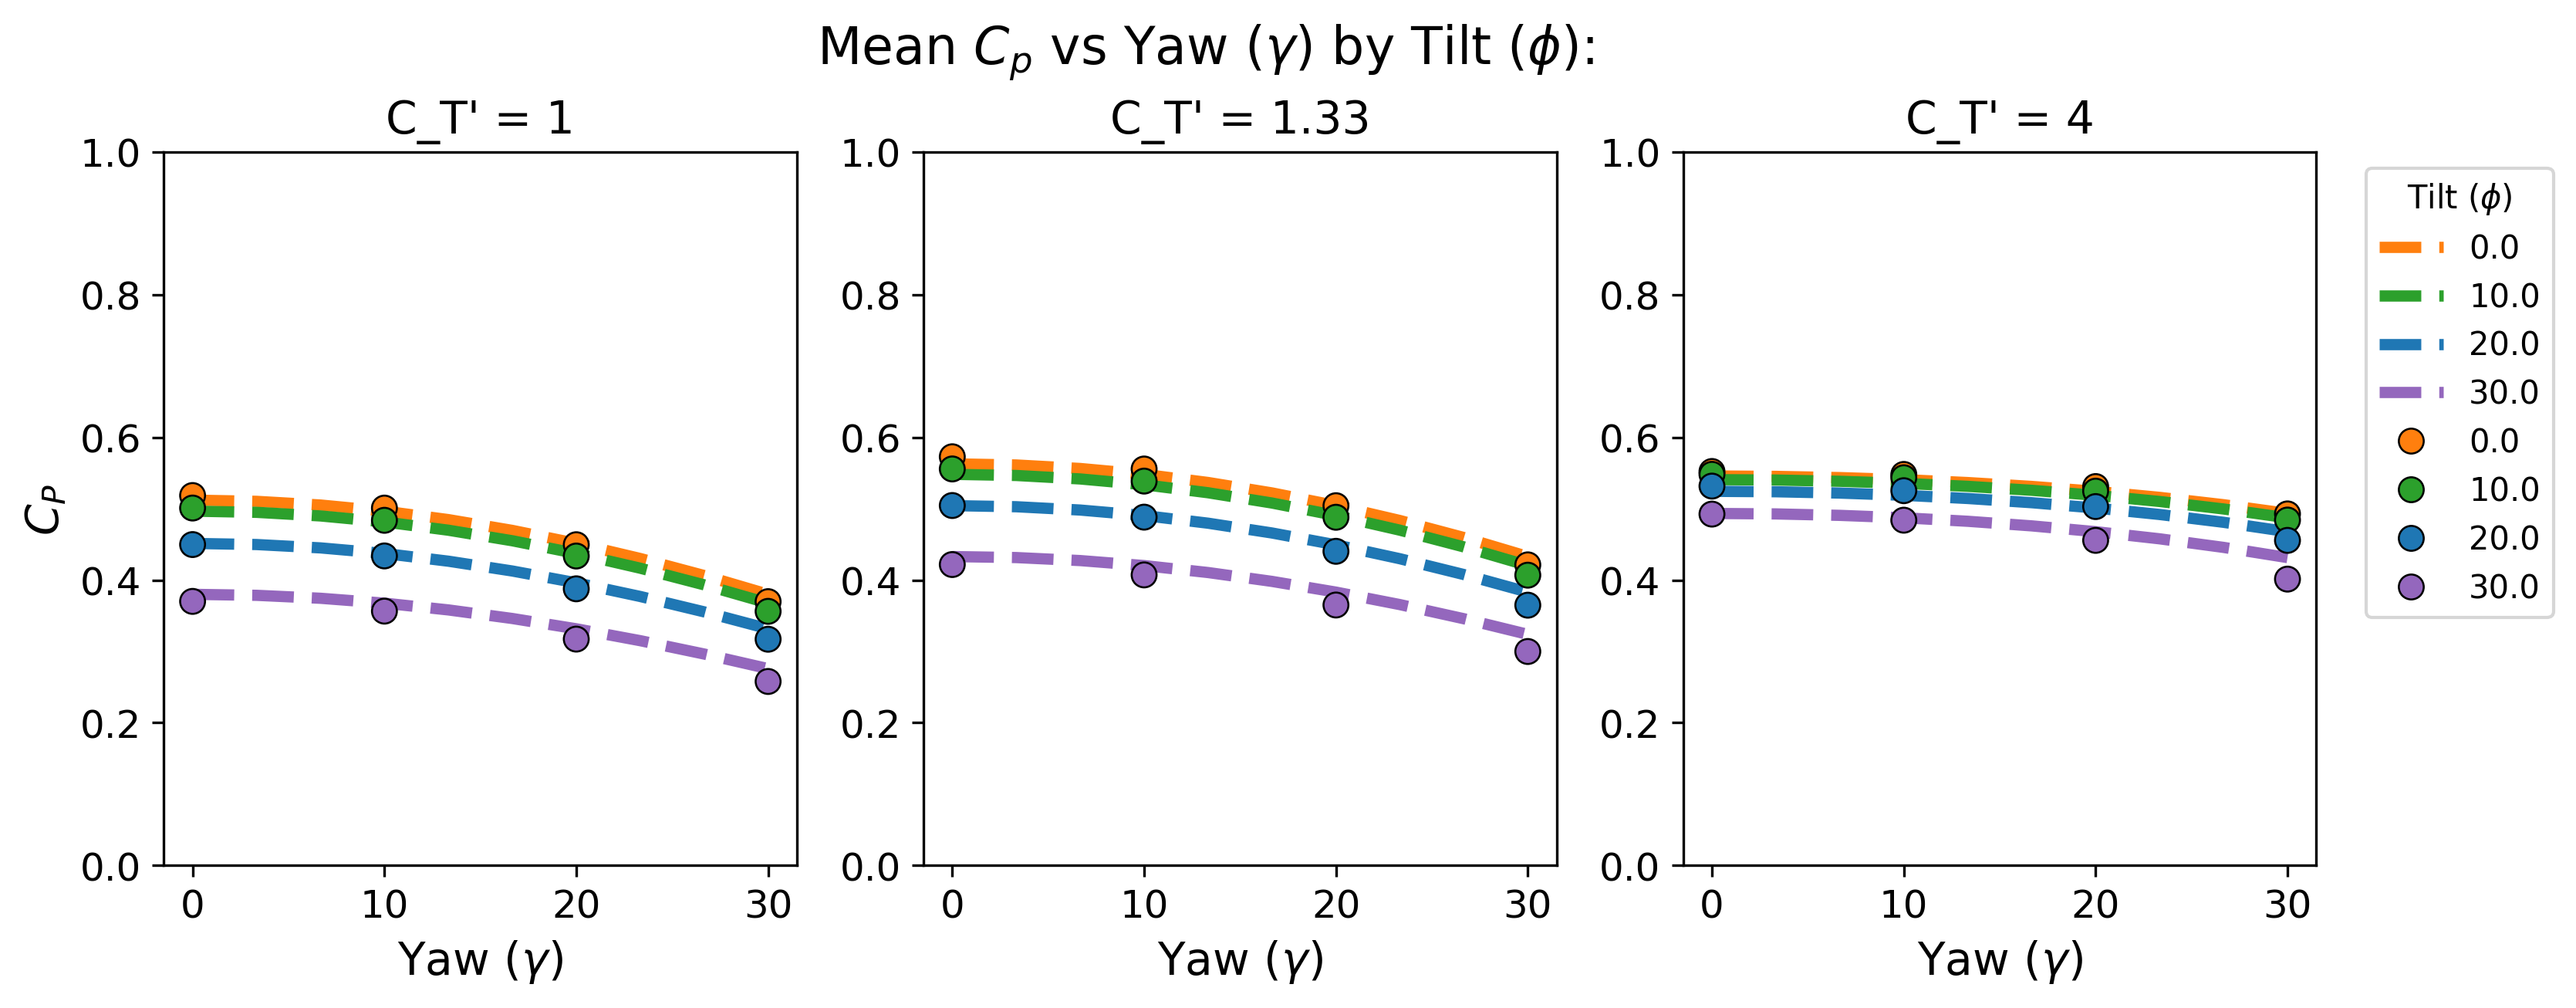

In [57]:
cp_fig, (cp_ax0, cp_ax1, cp_ax2) = cp_plots(limited_tilt_umm_df)

sns.scatterplot(ax = cp_ax0, data = les_df[les_df["Ctprime"] == 1],  x = "yaw", y = "Cp", hue = "tilt", palette = palette, s = 60, edgecolors = "k", zorder = 5)

leg = cp_ax0.legend(title='Tilt ($\phi$)')
bb = leg.get_bbox_to_anchor().transformed(cp_ax0.transAxes.inverted())
xOffset = 2.8
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = cp_ax0.transAxes)

sns.scatterplot(ax = cp_ax1, data = les_df[les_df["Ctprime"] == 1.33],  x = "yaw", y = "Cp", hue = "tilt", palette = palette, s = 60, edgecolors = "k", legend = False,  zorder = 5)
sns.scatterplot(ax = cp_ax2, data = les_df[(les_df["Ctprime"] == 4) & (les_df["budget"] == False)],  x = "yaw", y = "Cp", hue = "tilt", palette = palette, s = 60, edgecolors = "k", legend = False,  zorder = 5)

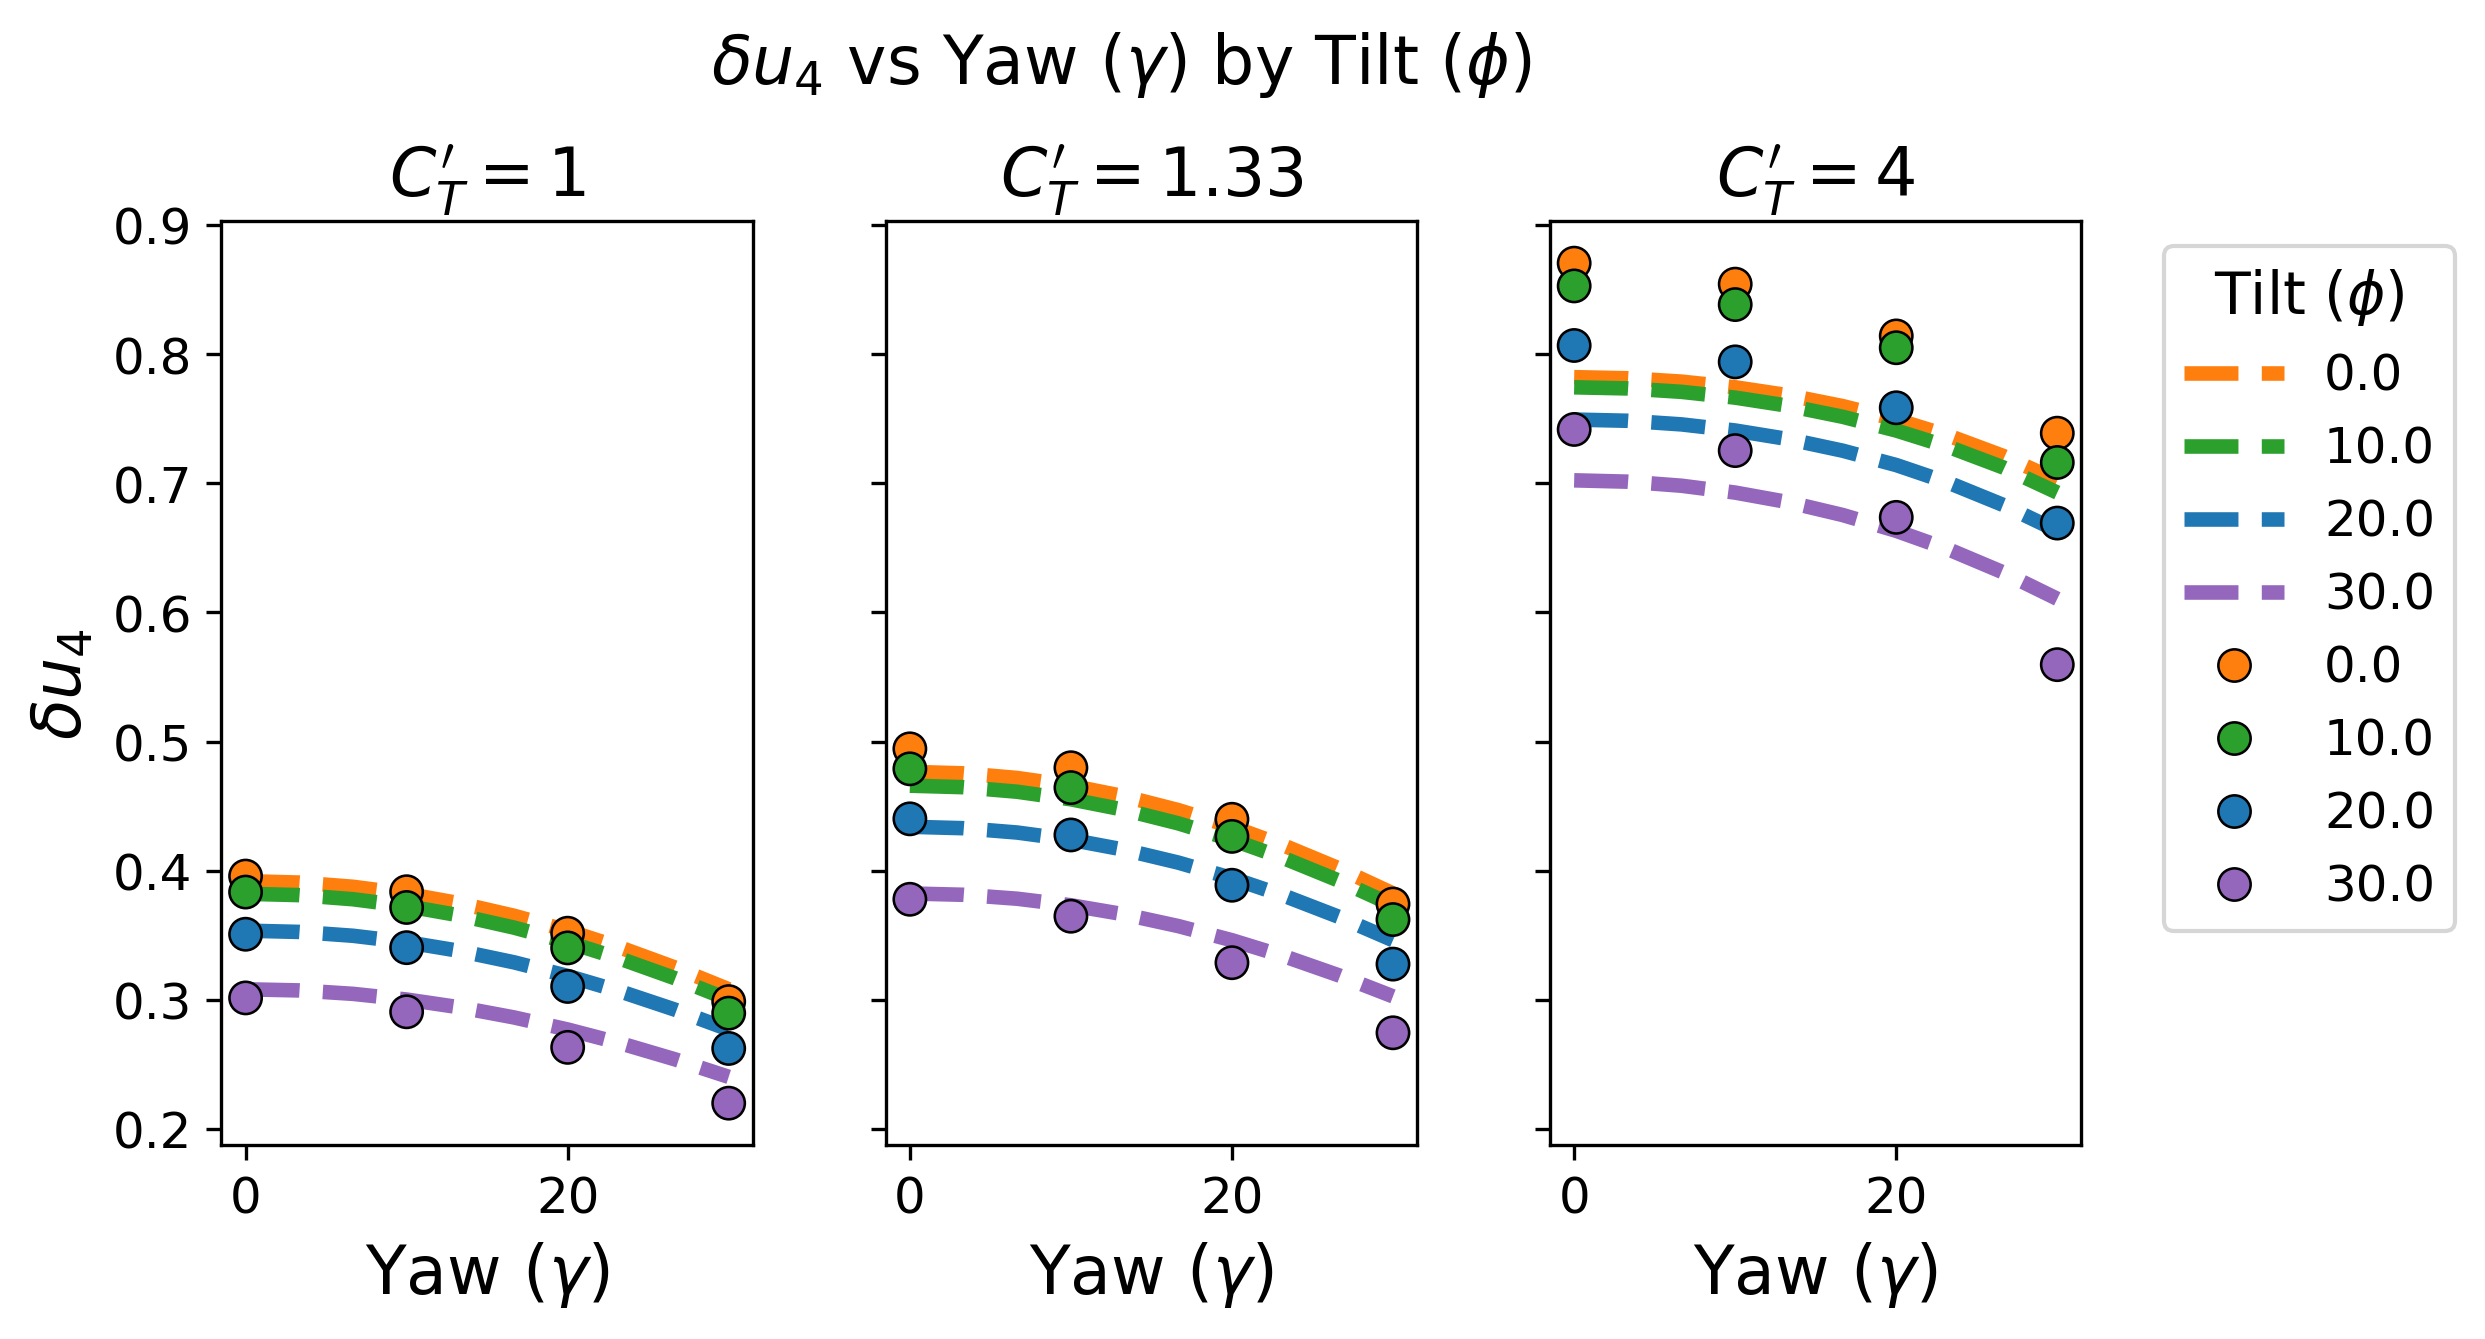

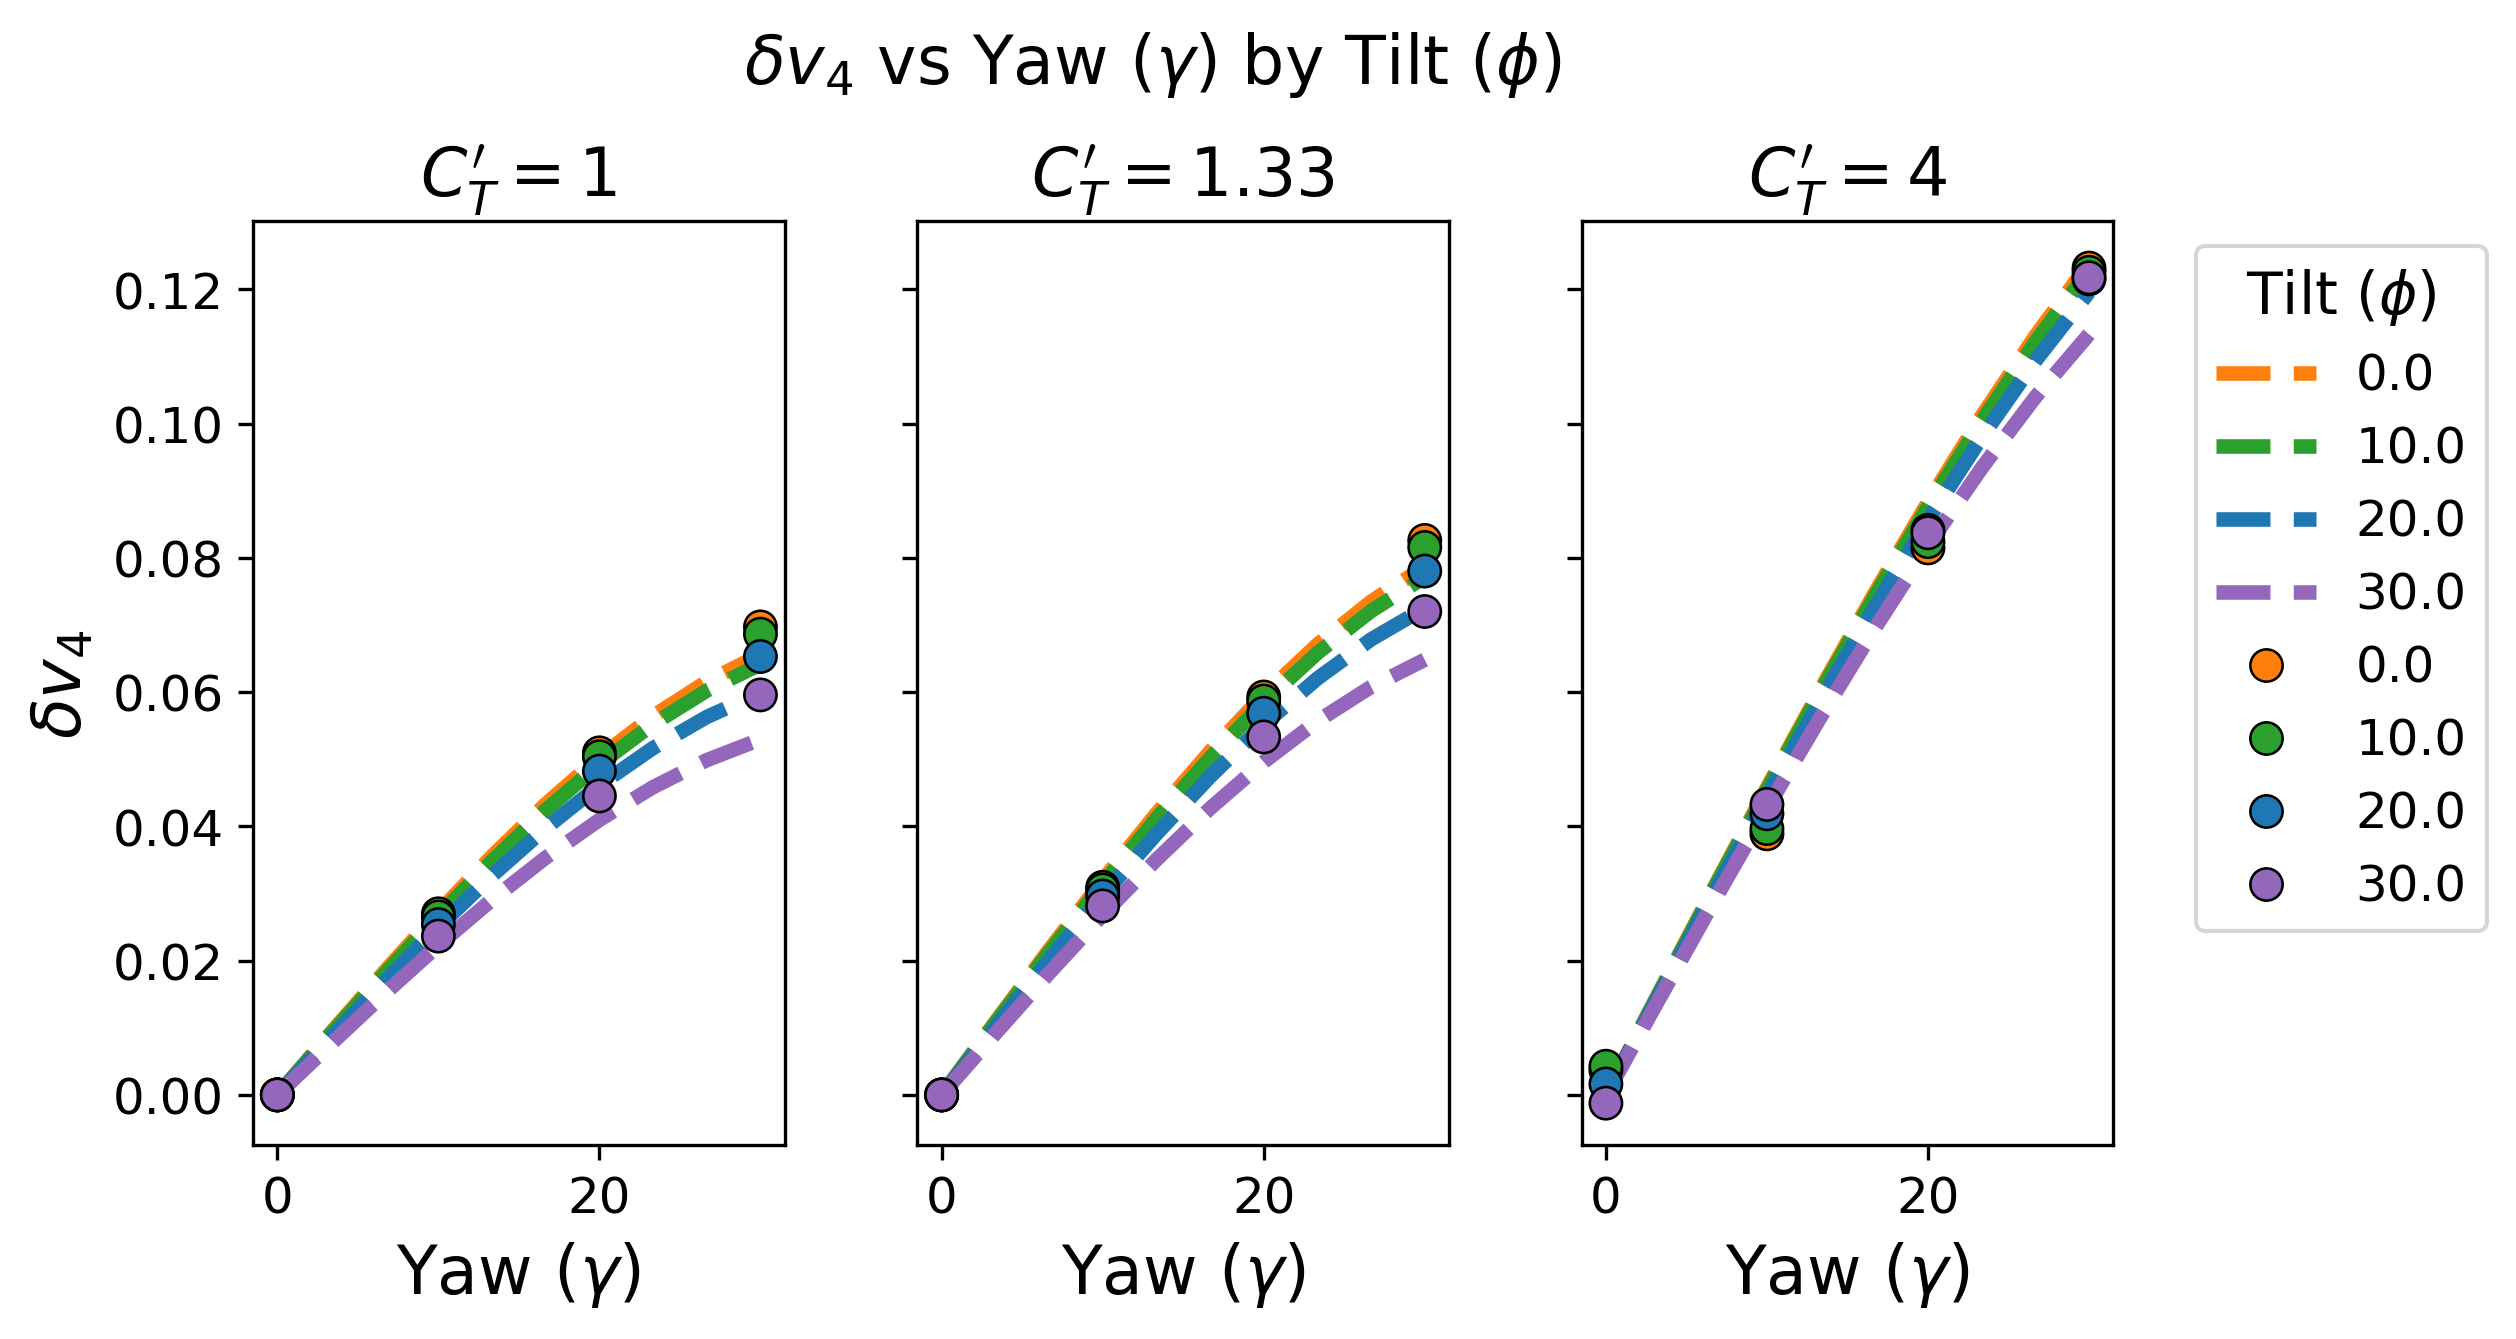

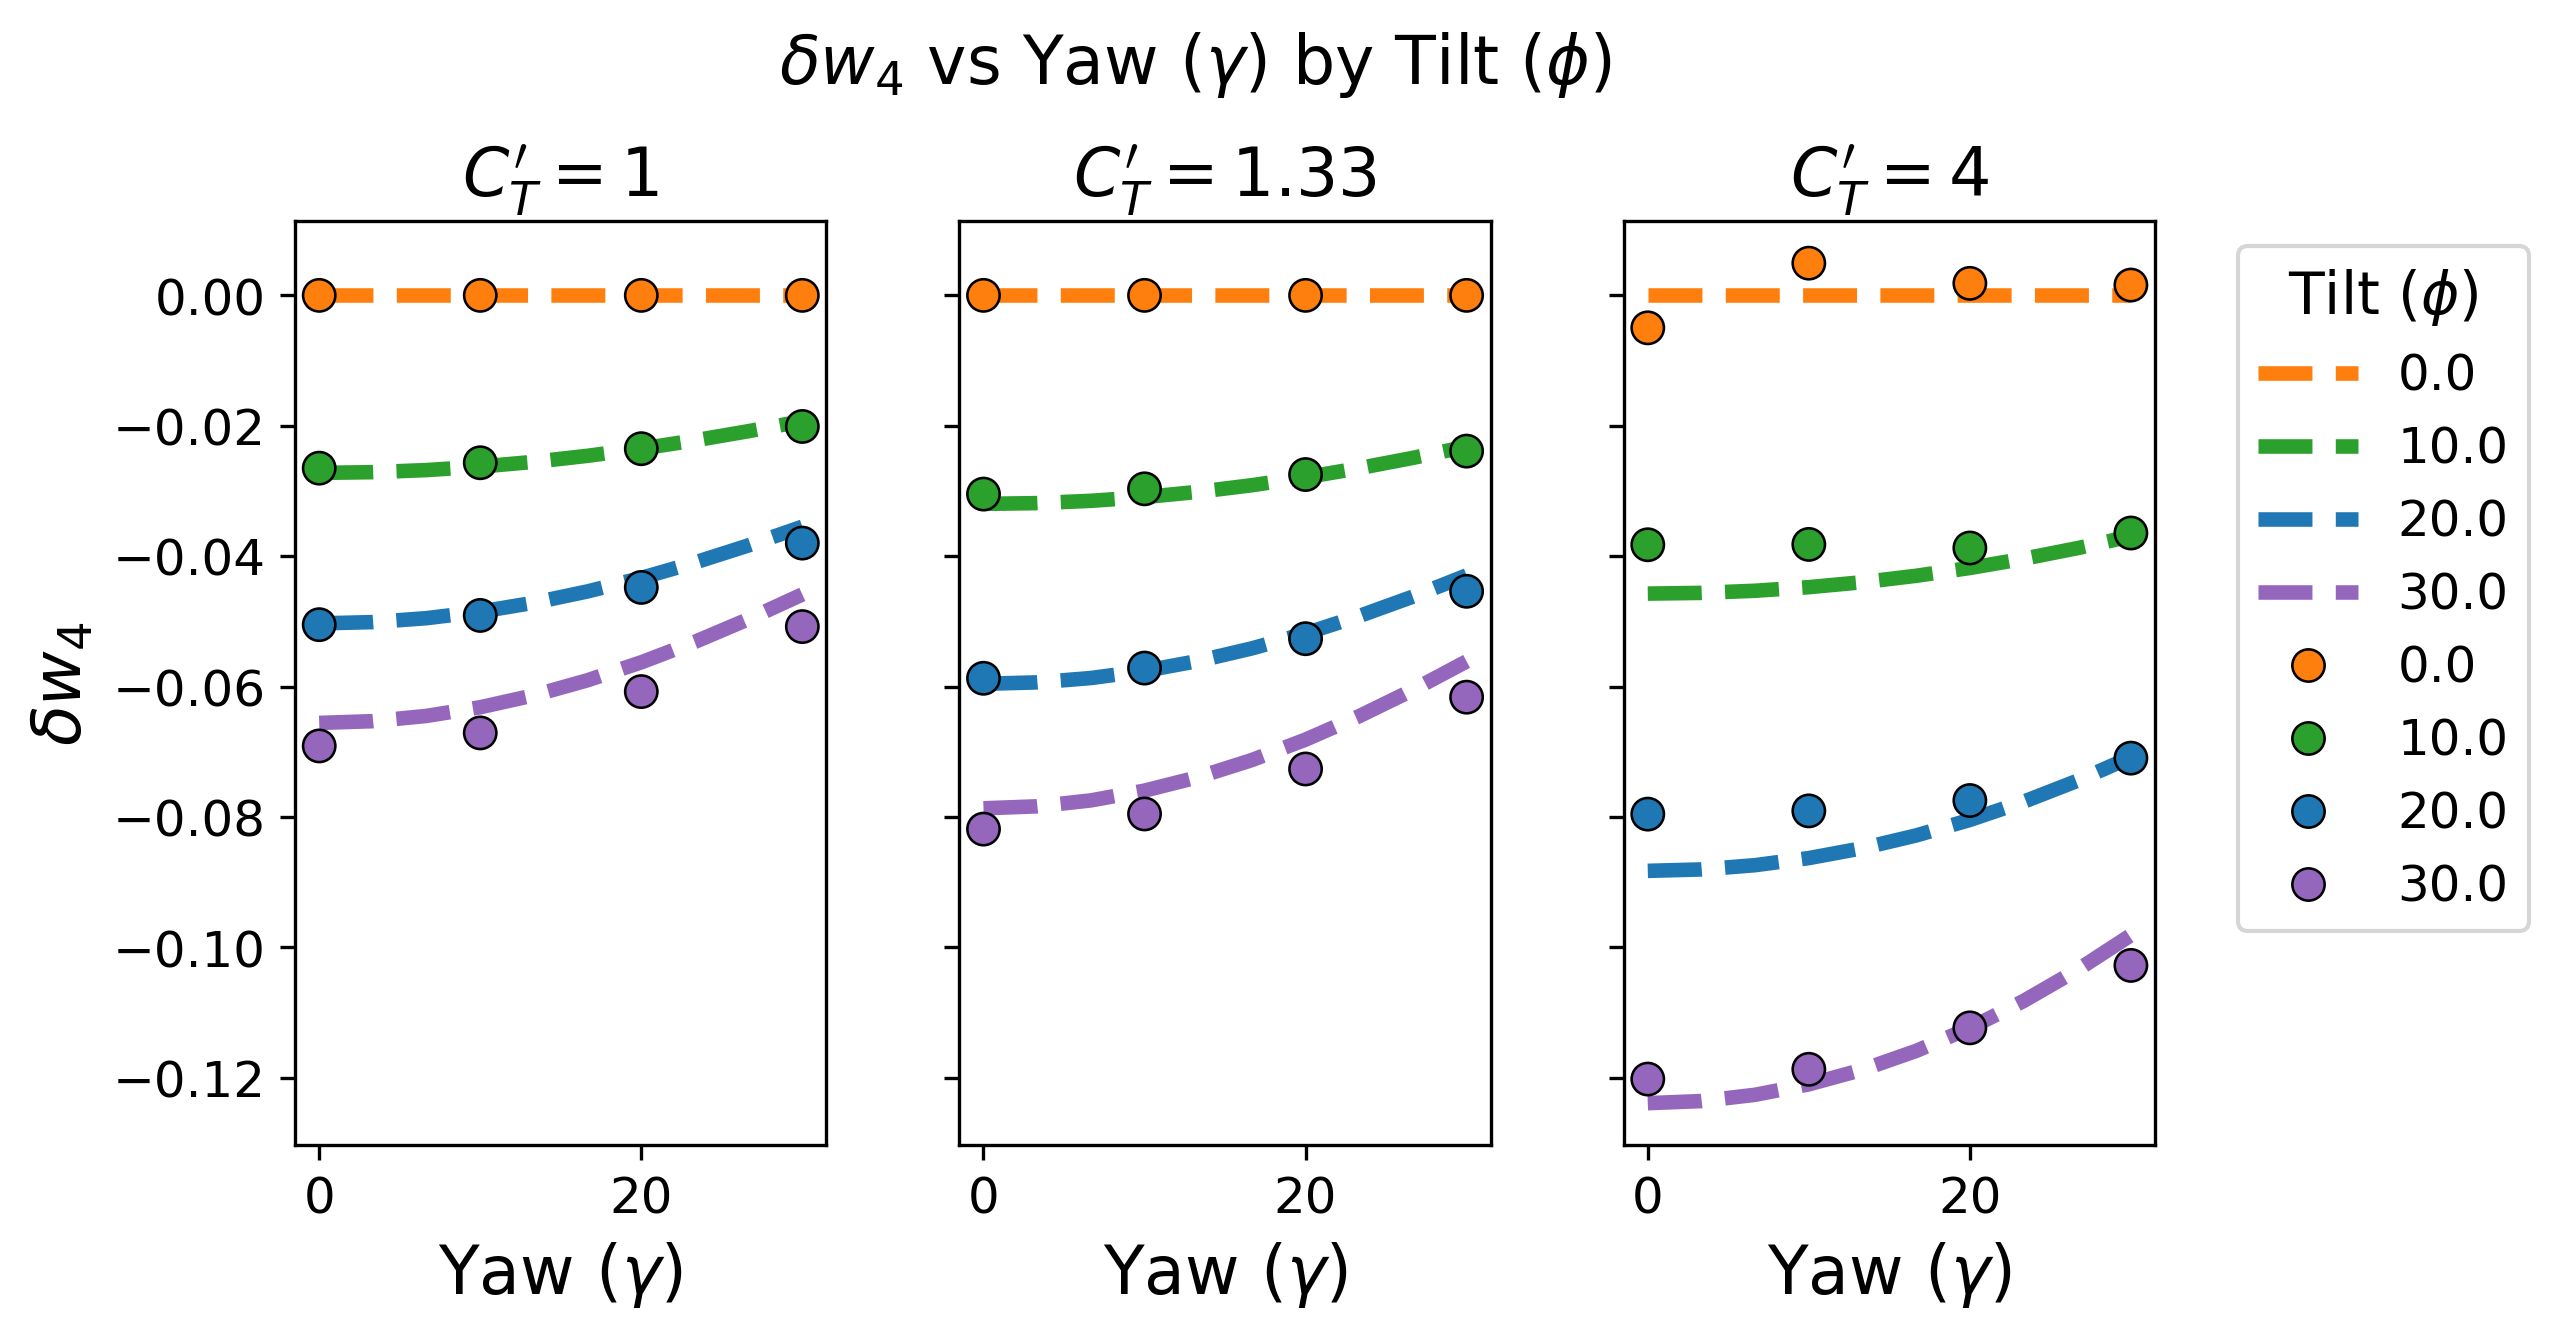

In [58]:
(vels_fig0, vels_ax0), (vels_fig1, vels_ax1), (vels_fig2, vels_ax2) = plot_vels(limited_tilt_umm_df)

ctprimes = [1, 1.33, 4]
for (i, ax) in enumerate(vels_ax0):
    legend = True if i == 0 else False
    budget = False if ctprimes[i] == 1 else True
    df = les_df[(les_df["Ctprime"] == ctprimes[i]) & (les_df["budget"] == budget)]
    sns.scatterplot(ax = ax, data = df,  x = "yaw", y = "du4", hue = "tilt", palette = palette, s = 60, edgecolors = "k", zorder = 5, legend = legend)
leg0 = vels_ax0[0].legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)
bb = leg0.get_bbox_to_anchor().transformed(vels_ax0[0].transAxes.inverted())
xOffset = 3.25
bb.x0 += xOffset
bb.x1 += xOffset
leg0 = leg0.set_bbox_to_anchor(bb, transform = vels_ax0[0].transAxes)

for (i, ax) in enumerate(vels_ax1):
    legend = True if i == 0 else False
    budget = False if ctprimes[i] == 1 else True
    df = les_df[(les_df["Ctprime"] == ctprimes[i]) & (les_df["budget"] == budget)]
    sns.scatterplot(ax = ax, data = df,  x = "yaw", y = "dv4", hue = "tilt", palette = palette, s = 60, edgecolors = "k", zorder = 5, legend = legend)
leg1 = vels_ax1[0].legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)
bb = leg1.get_bbox_to_anchor().transformed(vels_ax1[0].transAxes.inverted())
xOffset = 3.25
bb.x0 += xOffset
bb.x1 += xOffset
leg1 = leg1.set_bbox_to_anchor(bb, transform = vels_ax1[0].transAxes)
 
for (i, ax) in enumerate(vels_ax2):
    legend = True if i == 0 else False
    budget = False if ctprimes[i] == 1 else True
    df = les_df[(les_df["Ctprime"] == ctprimes[i]) & (les_df["budget"] == budget)]
    sns.scatterplot(ax = ax, data = df,  x = "yaw", y = "dw4", hue = "tilt", palette = palette, s = 60, edgecolors = "k", zorder = 5, legend = legend)
leg2 = vels_ax2[0].legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)
bb = leg2.get_bbox_to_anchor().transformed(vels_ax2[0].transAxes.inverted())
xOffset = 3.25
bb.x0 += xOffset
bb.x1 += xOffset
leg2 = leg2.set_bbox_to_anchor(bb, transform = vels_ax2[0].transAxes)

## Quantify Error

In [59]:
compare_umm_df = limited_yaw_tilt_umm_df[limited_yaw_tilt_umm_df["Ctprime"] == 1]
compare_les_df = les_df[les_df["Ctprime"] == 1]

cp_err_vals = []
du4_err_vals = []
dv4_err_vals = []
dw4_err_vals = []
for row_idx, row in compare_umm_df.iterrows():
    y, t = row["yaw"], row["tilt"]
    les_row = compare_les_df[(compare_les_df["tilt"] == t) & (compare_les_df["yaw"] == y)]
    cp_err_vals.append(((row["Cp"] - les_row["Cp"]) / les_row["Cp"]).item() * 100)
    du4_err_vals.append(((row["du4"] - les_row["du4"]) / les_row["du4"]).item() * 100)
    if y == 0:
        dv4_err_vals.append(np.nan)
    else:
        dv4_err_vals.append(((row["dv4"] - les_row["dv4"]) / les_row["dv4"]).item() * 100)
    if t == 0:
        dw4_err_vals.append(np.nan)
    else:
        dw4_err_vals.append(((row["dw4"] - les_row["dw4"]) / les_row["dw4"]).item() * 100 )

compare_umm_df["cp_err"] = cp_err_vals
compare_umm_df["du4_err"] = du4_err_vals
compare_umm_df["dv4_err"] = dv4_err_vals
compare_umm_df["dw4_err"] = dw4_err_vals

/tmp/ipykernel_2694918/3888804241.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_umm_df["cp_err"] = cp_err_vals
/tmp/ipykernel_2694918/3888804241.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_umm_df["du4_err"] = du4_err_vals
/tmp/ipykernel_2694918/3888804241.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [60]:
def plot_error_barplot(data, err_col, err_name):
    fig, ax0 = plt.subplots(dpi = 300)
    ax0.set_title(f"{err_name} vs Yaw ($\gamma$) by Tilt ($\phi$) for $C_T' = 1$", size = 16)
    ax0.set_ylabel(f"{err_name} (%)", size = 16)
    ax0.set_xlabel('Yaw ($\\gamma$)', size = 16)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    sns.barplot(data, x="yaw", y=err_col, hue="tilt", palette = palette)
    ax0.legend(title='Tilt ($\phi$)', title_fontsize=14, fontsize=12)
    return

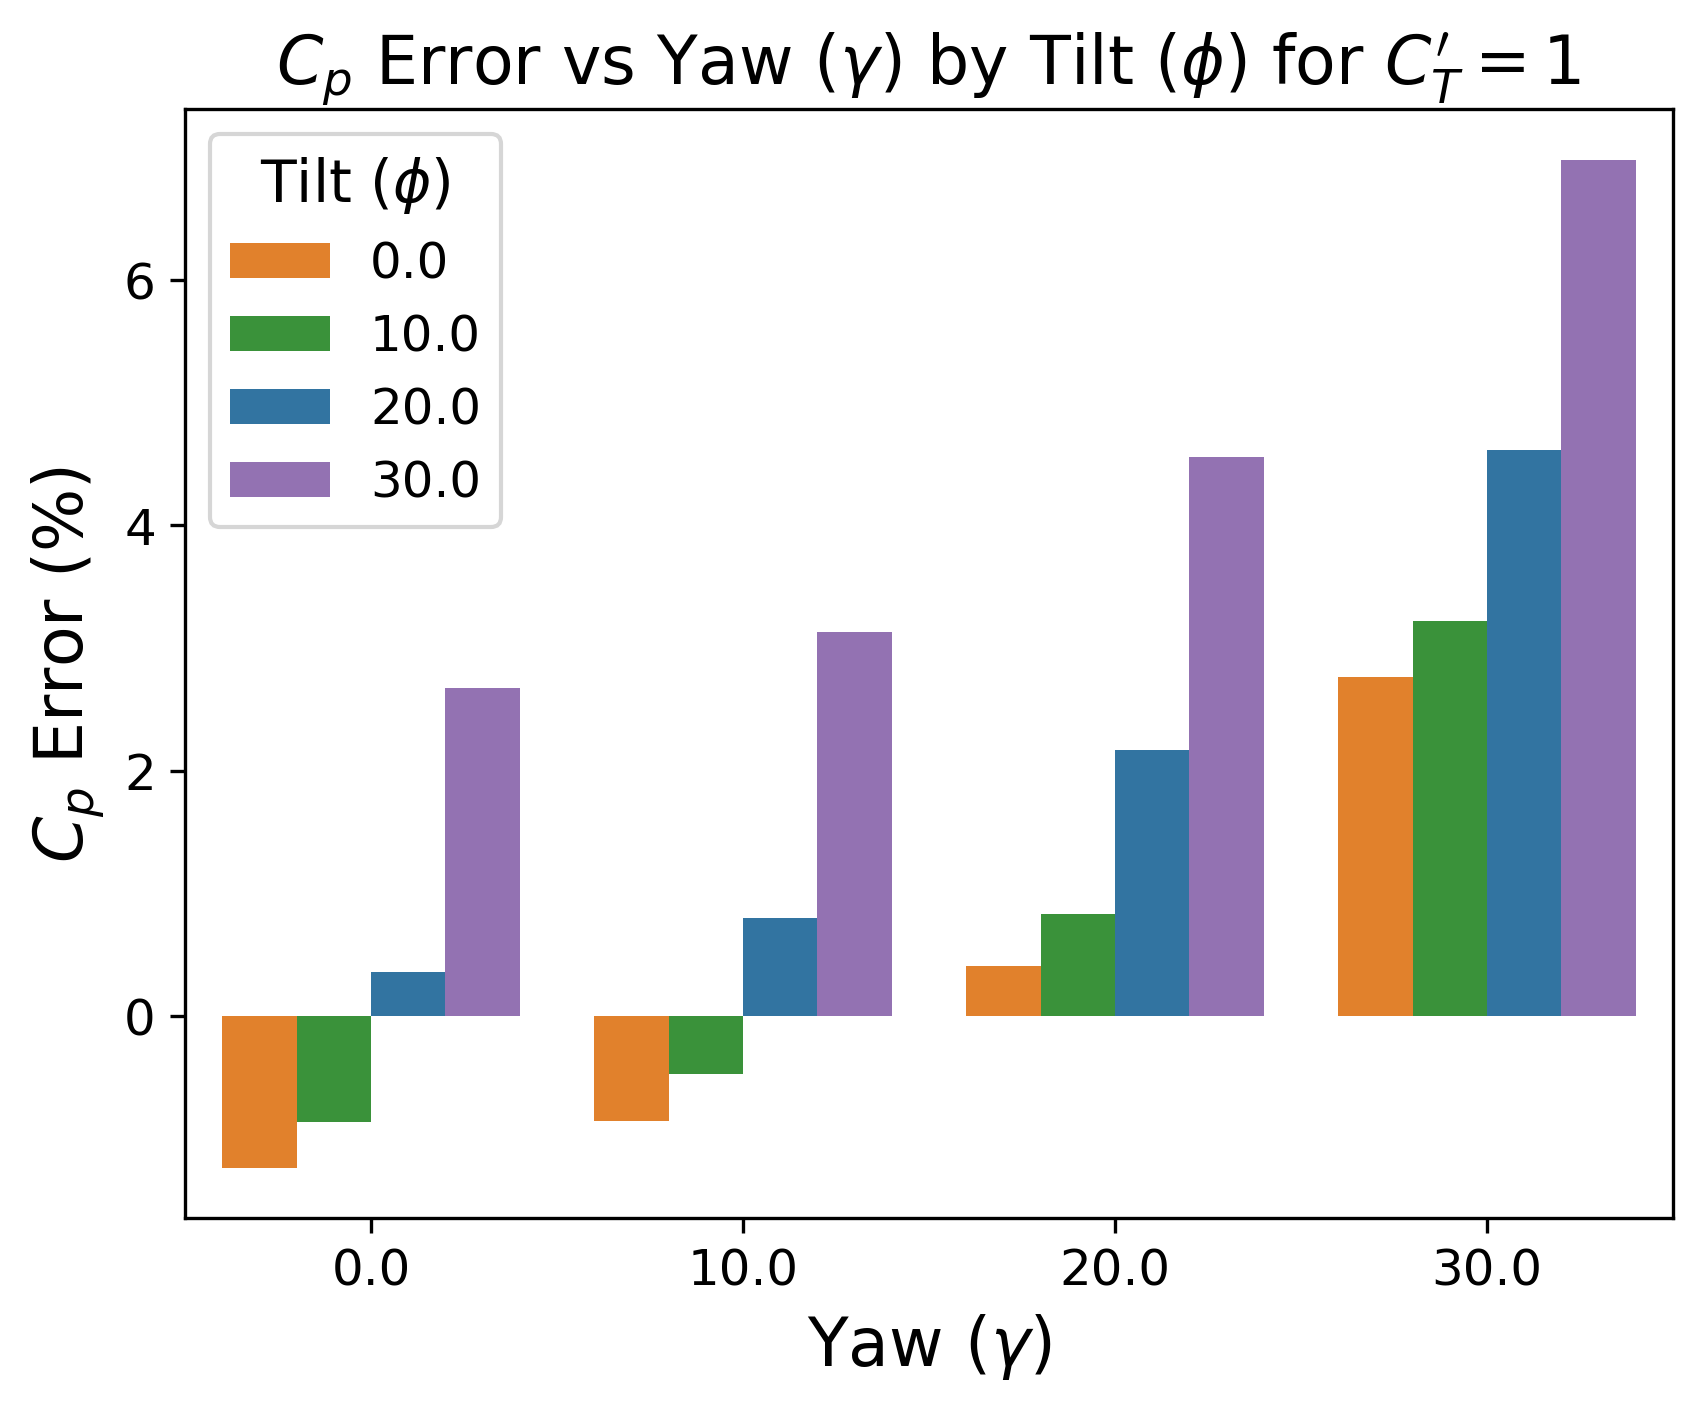

In [61]:
plot_error_barplot(compare_umm_df, "cp_err", "$C_p$ Error")

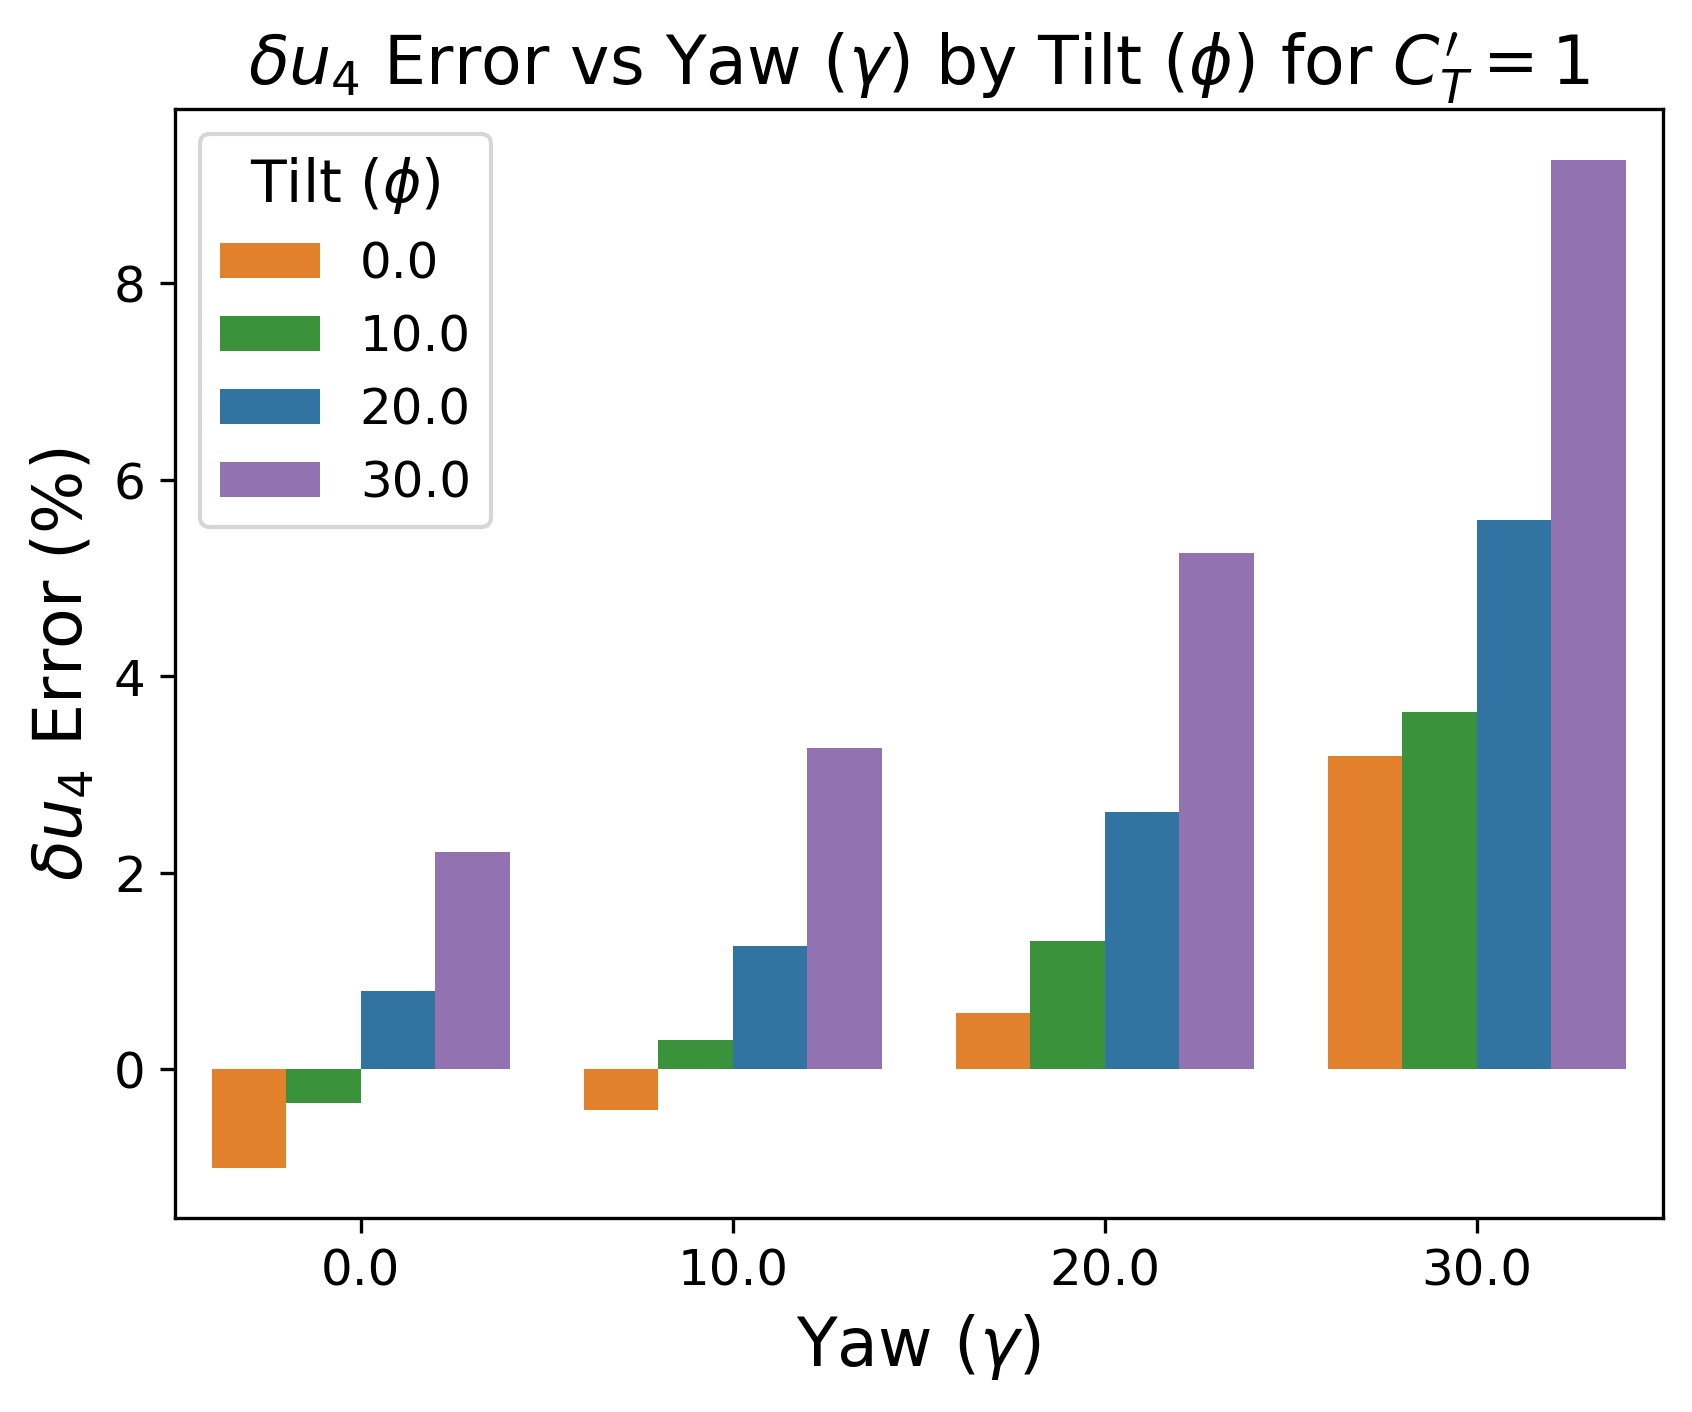

In [62]:
plot_error_barplot(compare_umm_df, "du4_err", "$\delta u_4$ Error")

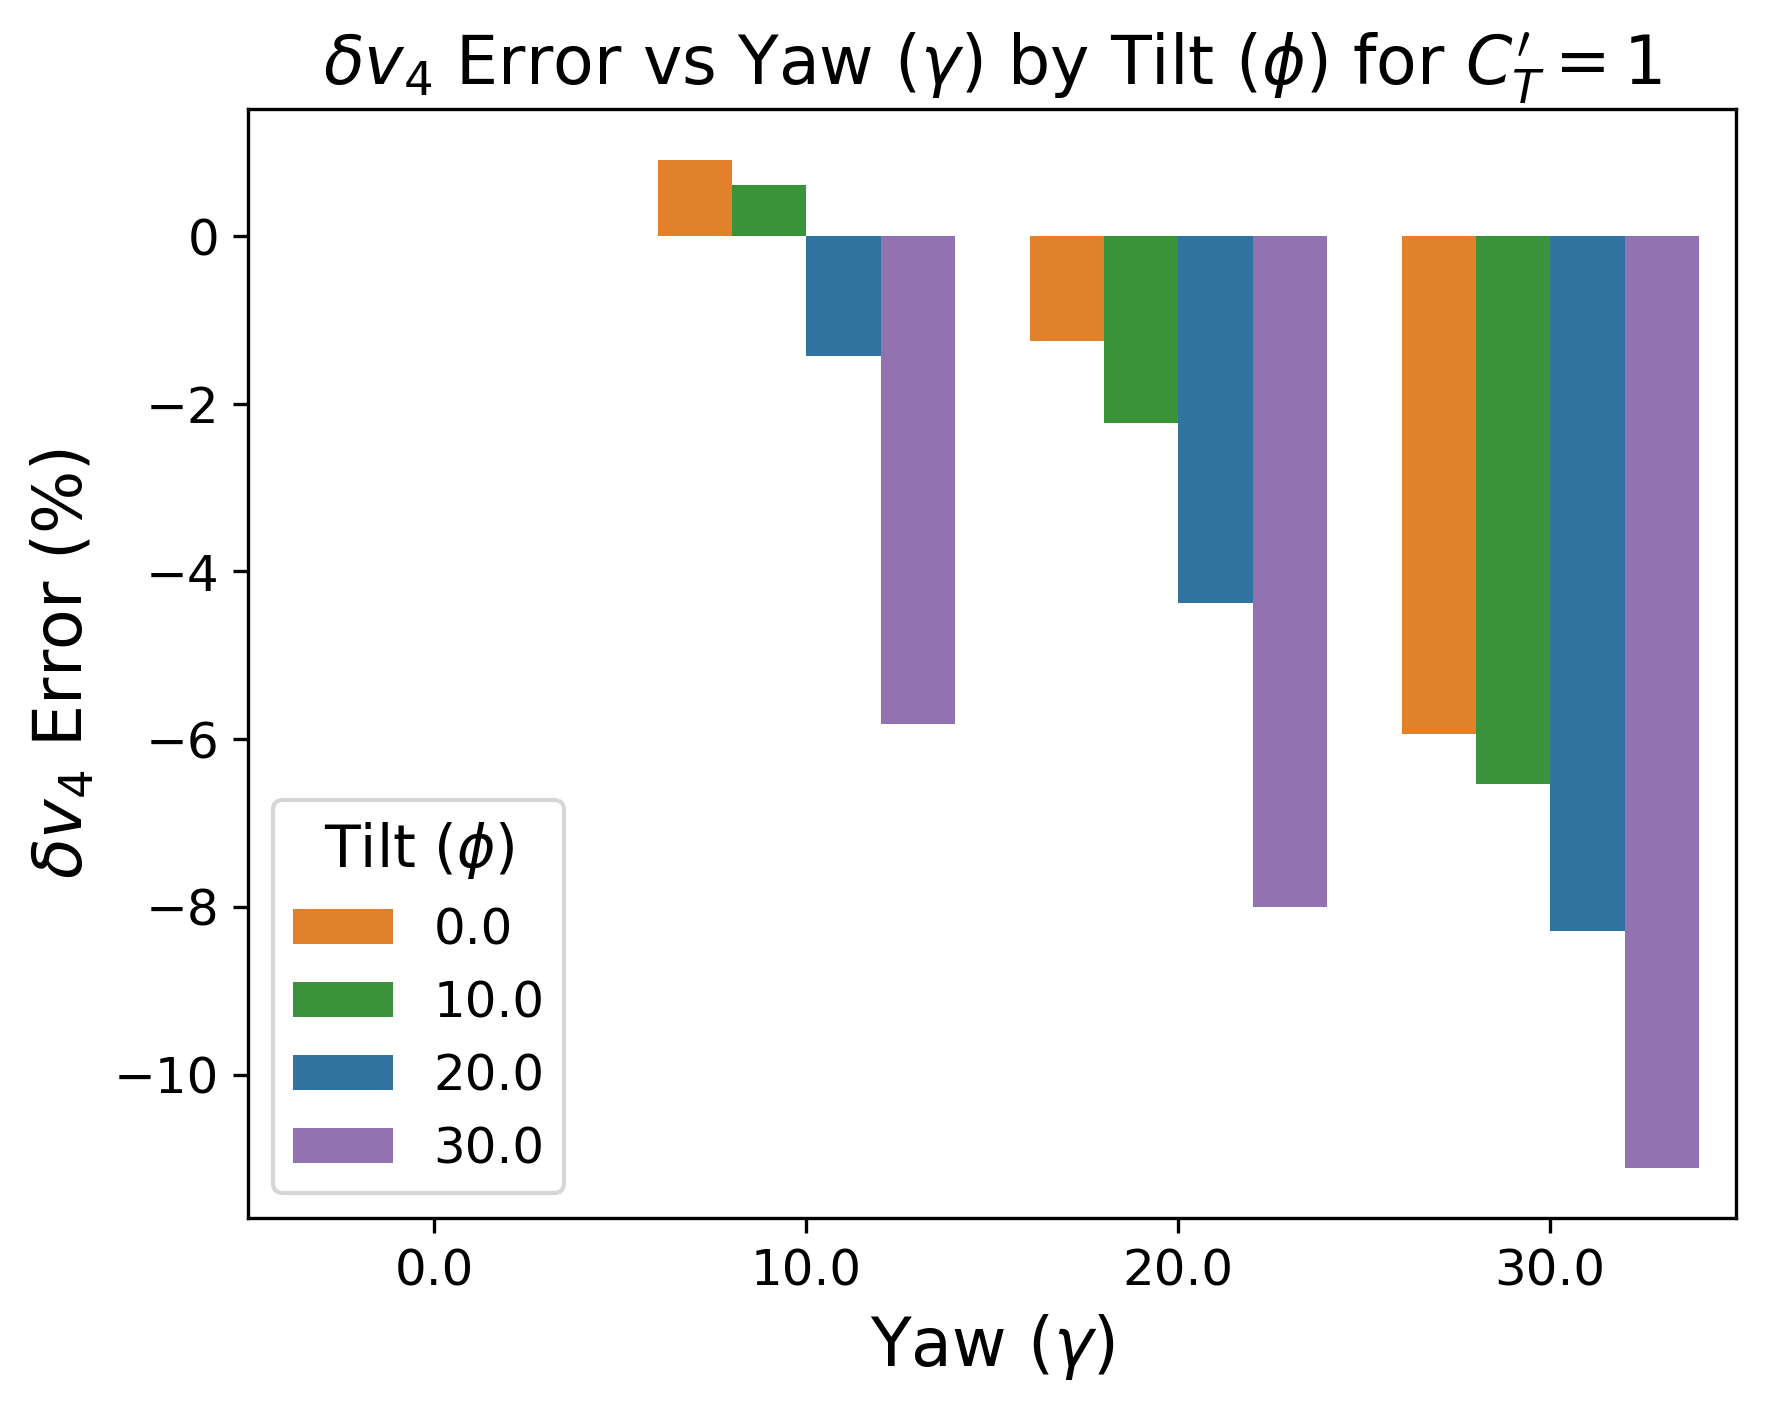

In [63]:
plot_error_barplot(compare_umm_df, "dv4_err", "$\delta v_4$ Error")

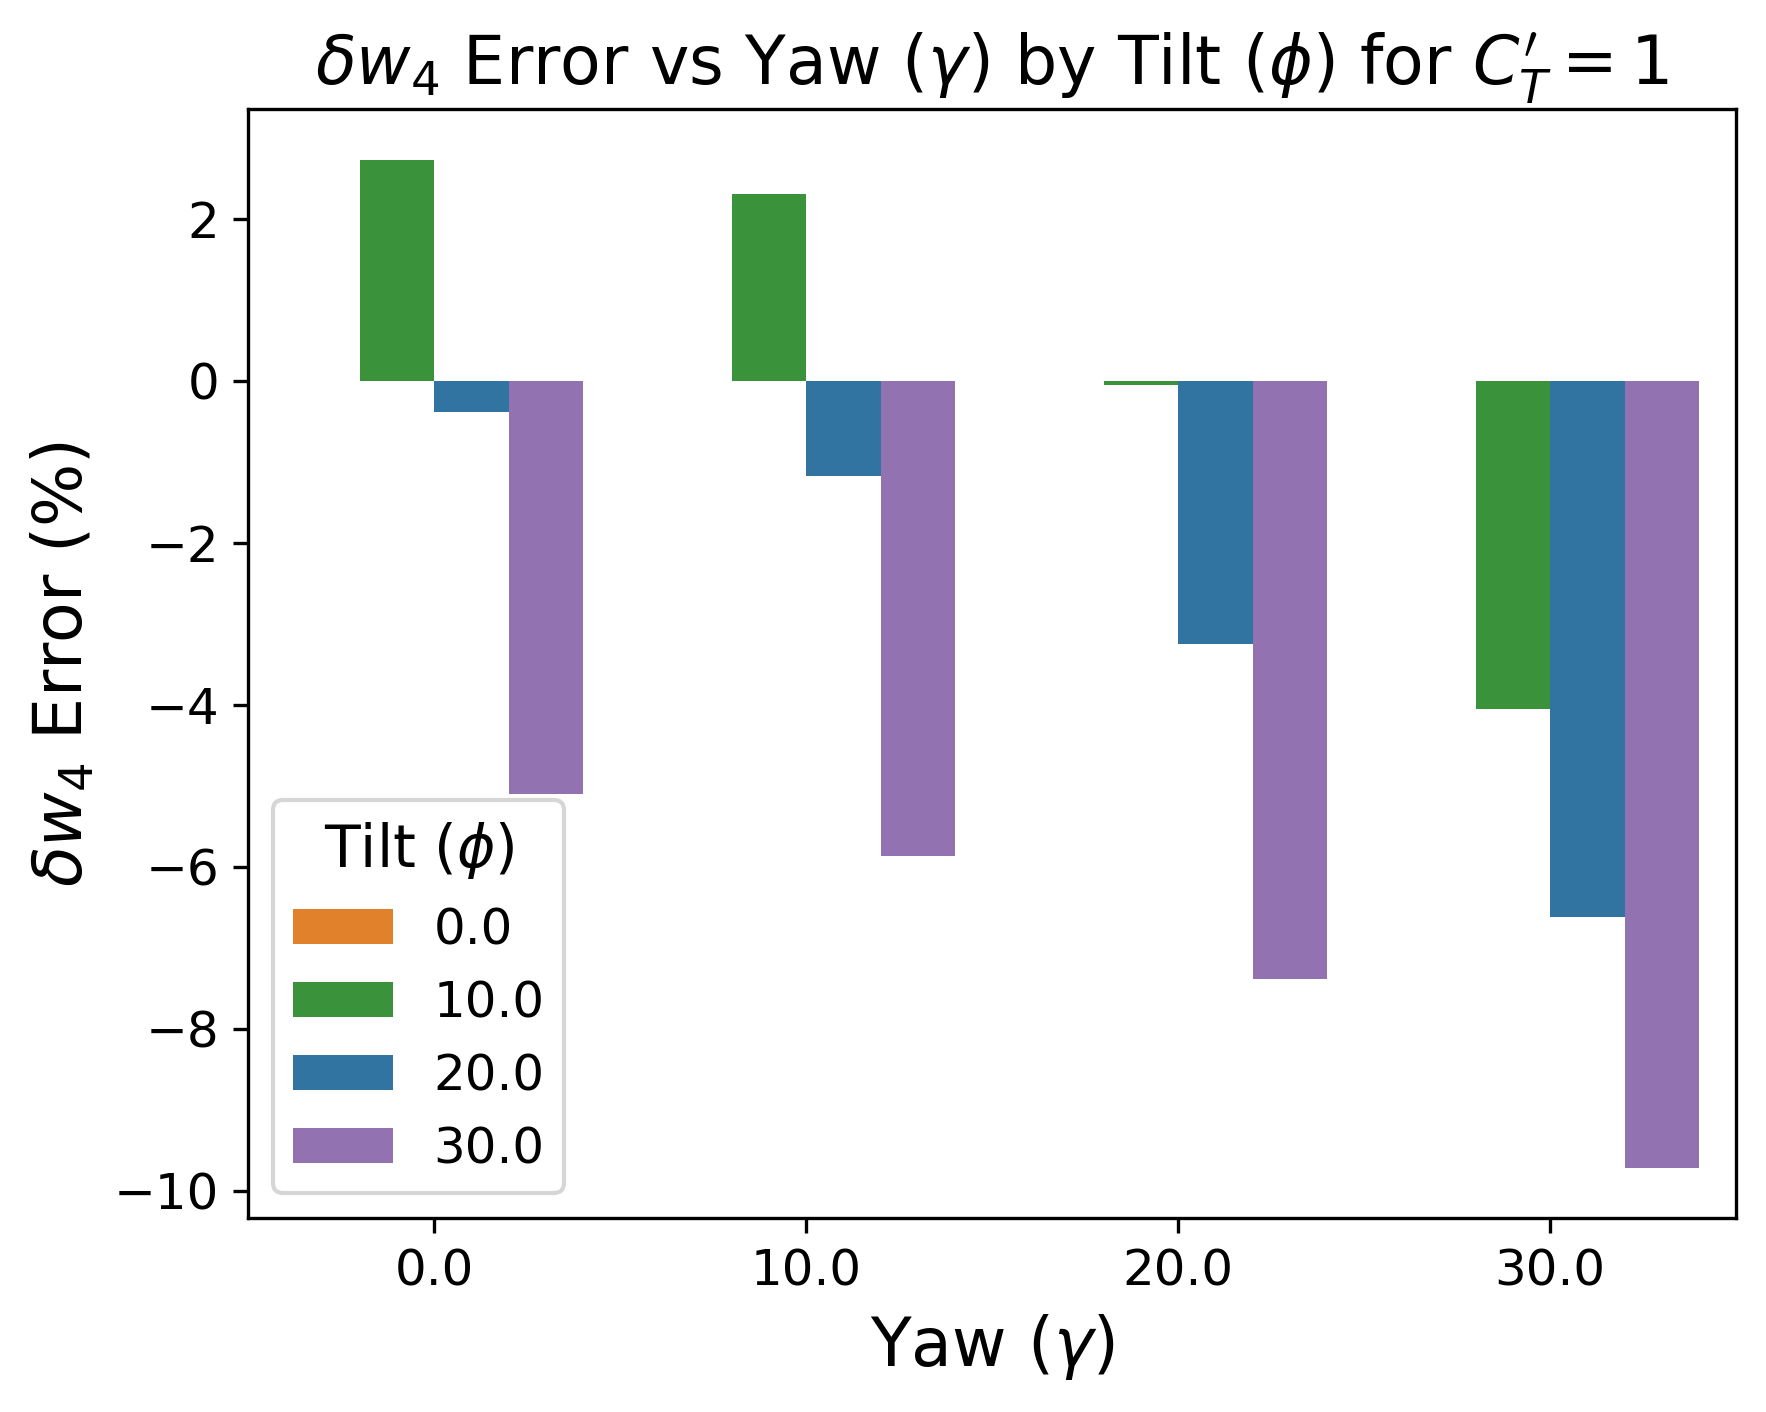

In [64]:
plot_error_barplot(compare_umm_df, "dw4_err", "$\delta w_4$ Error")

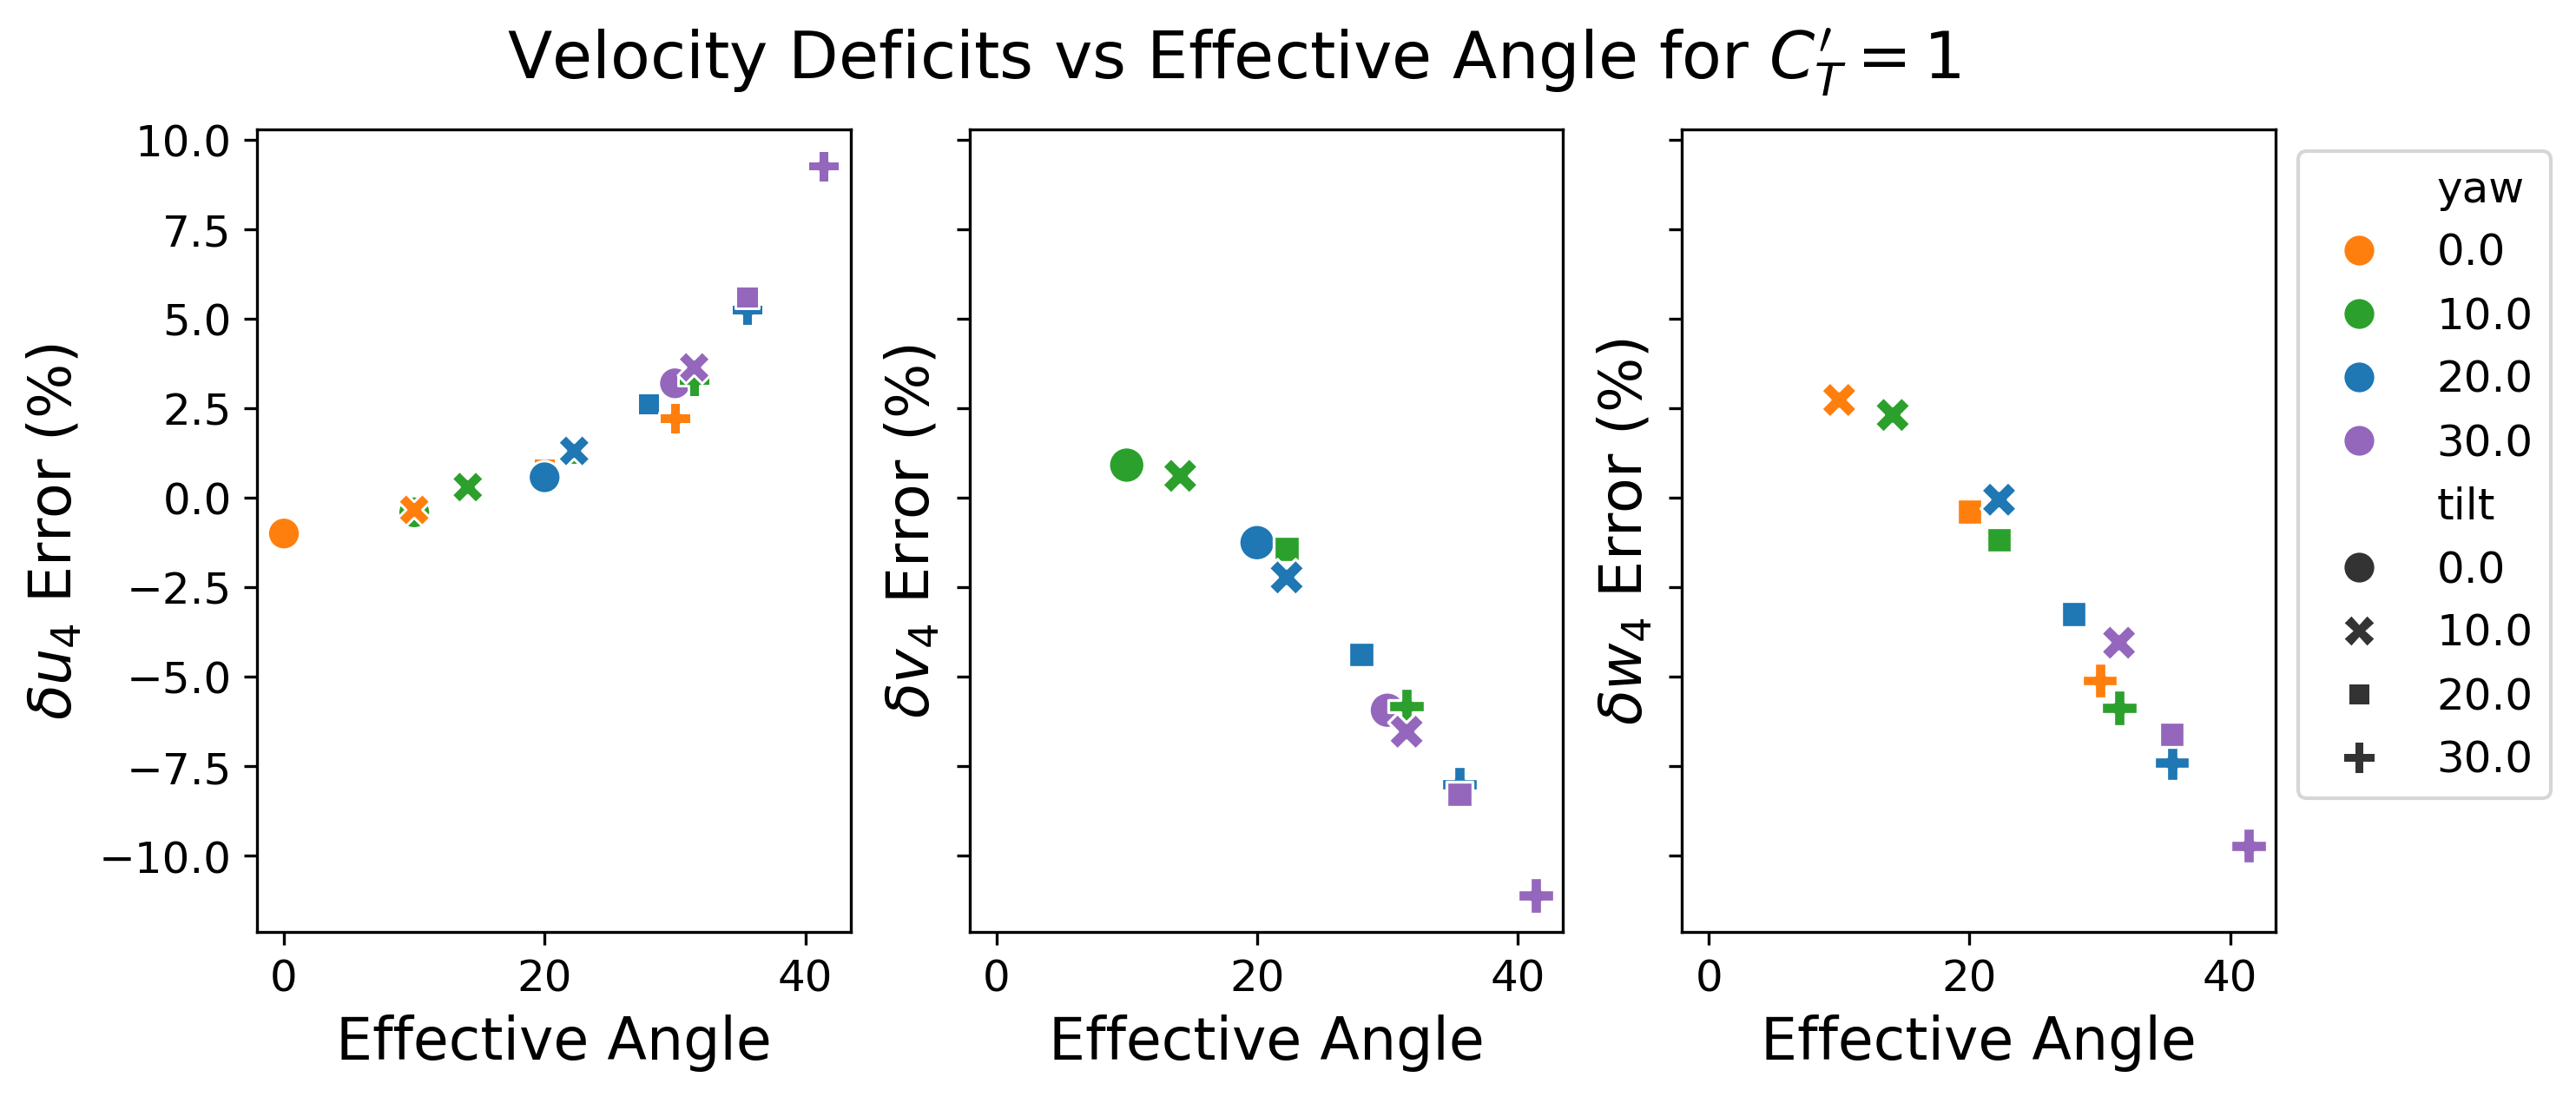

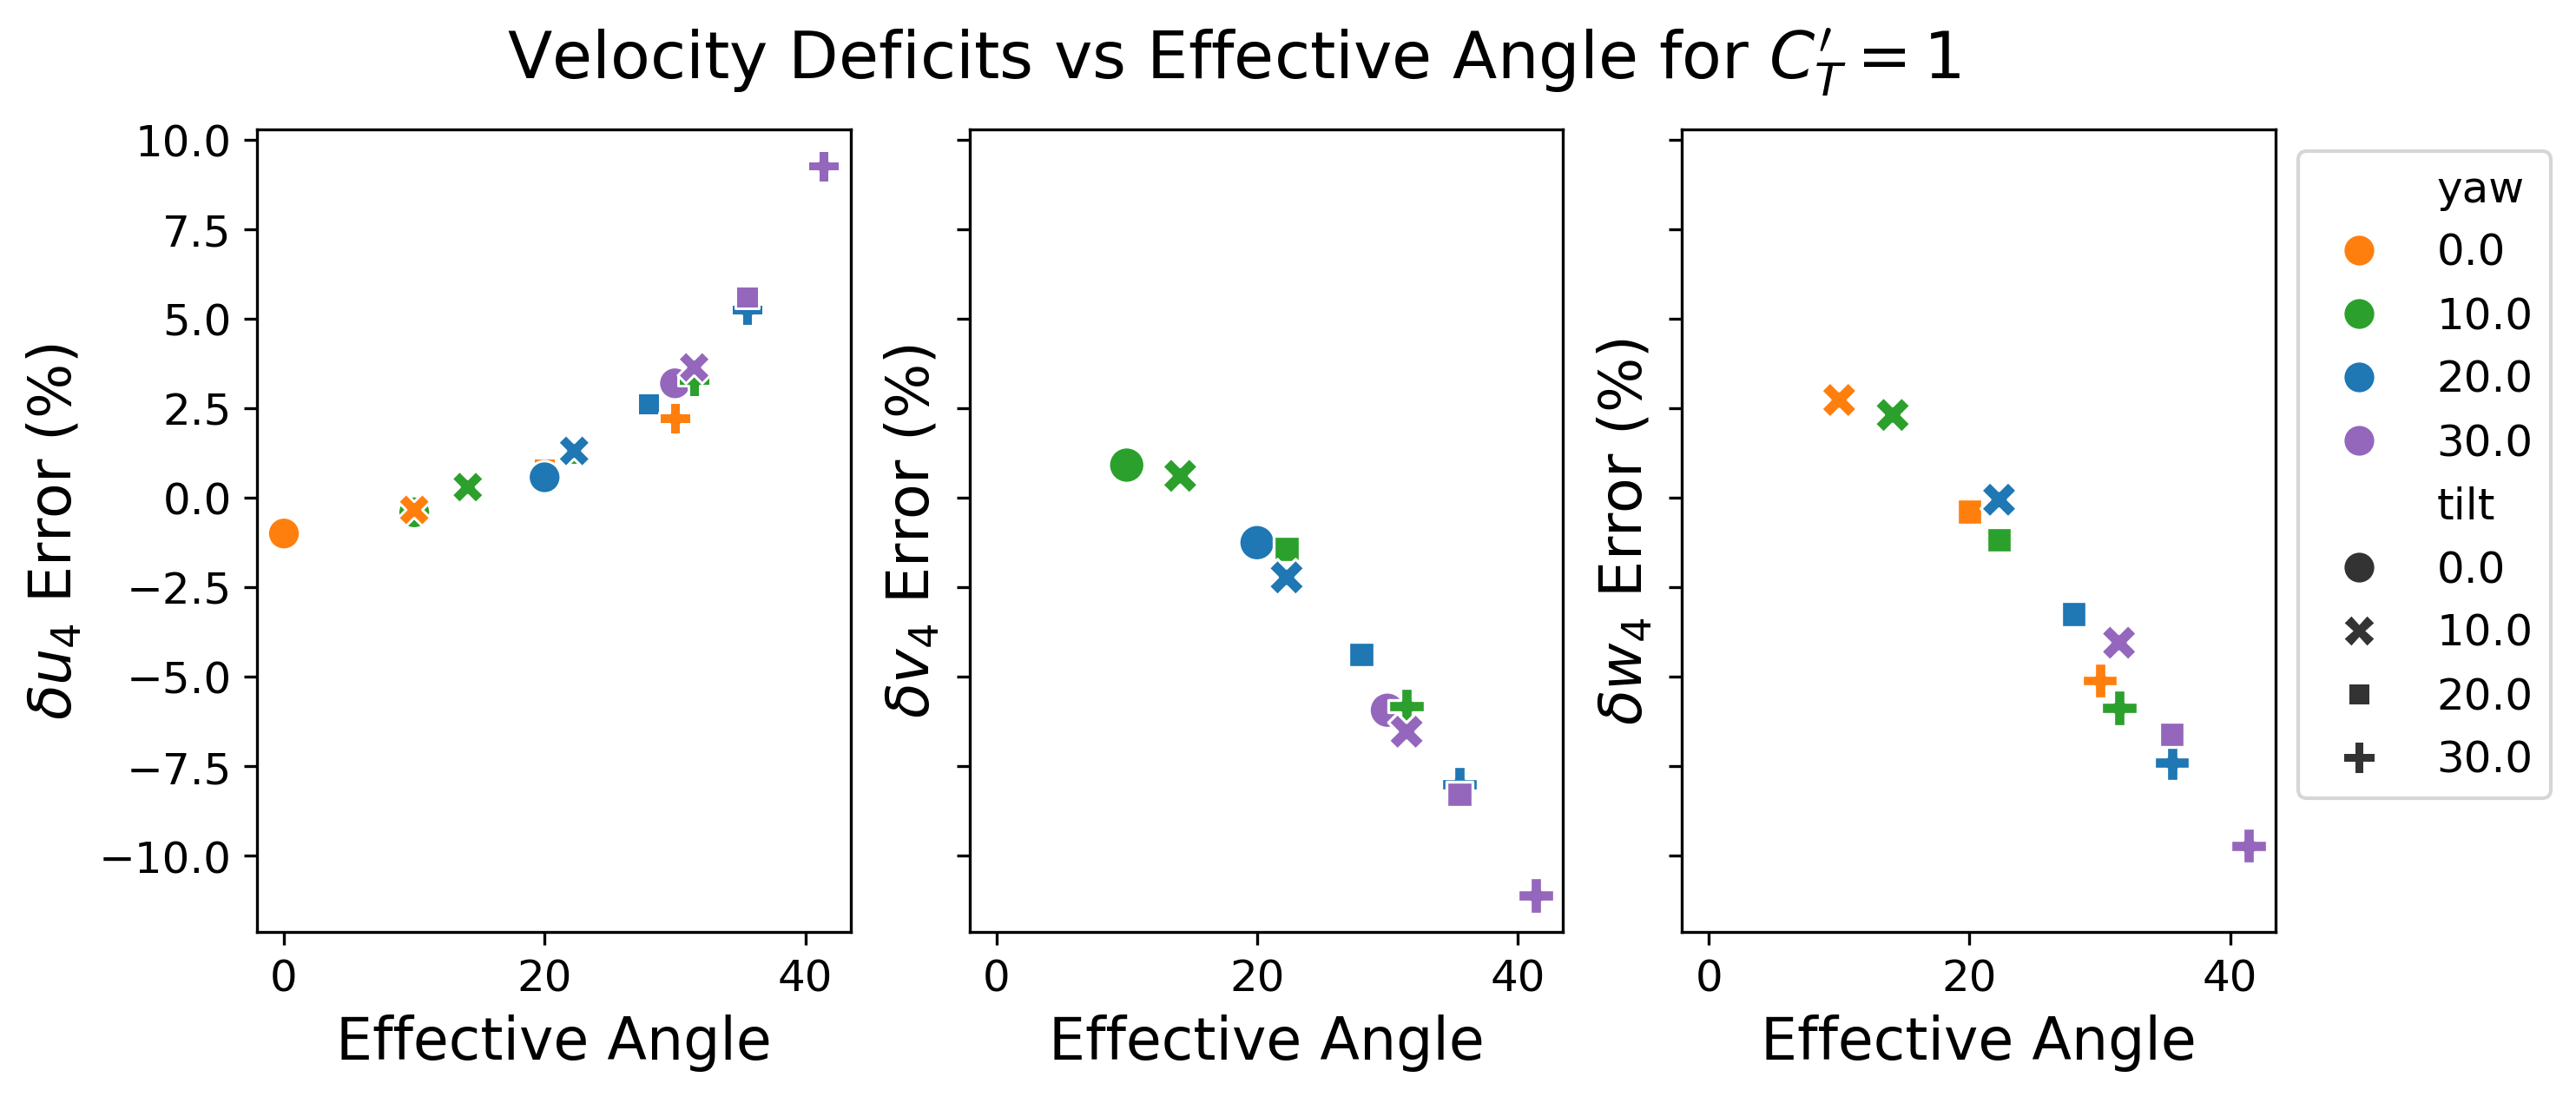

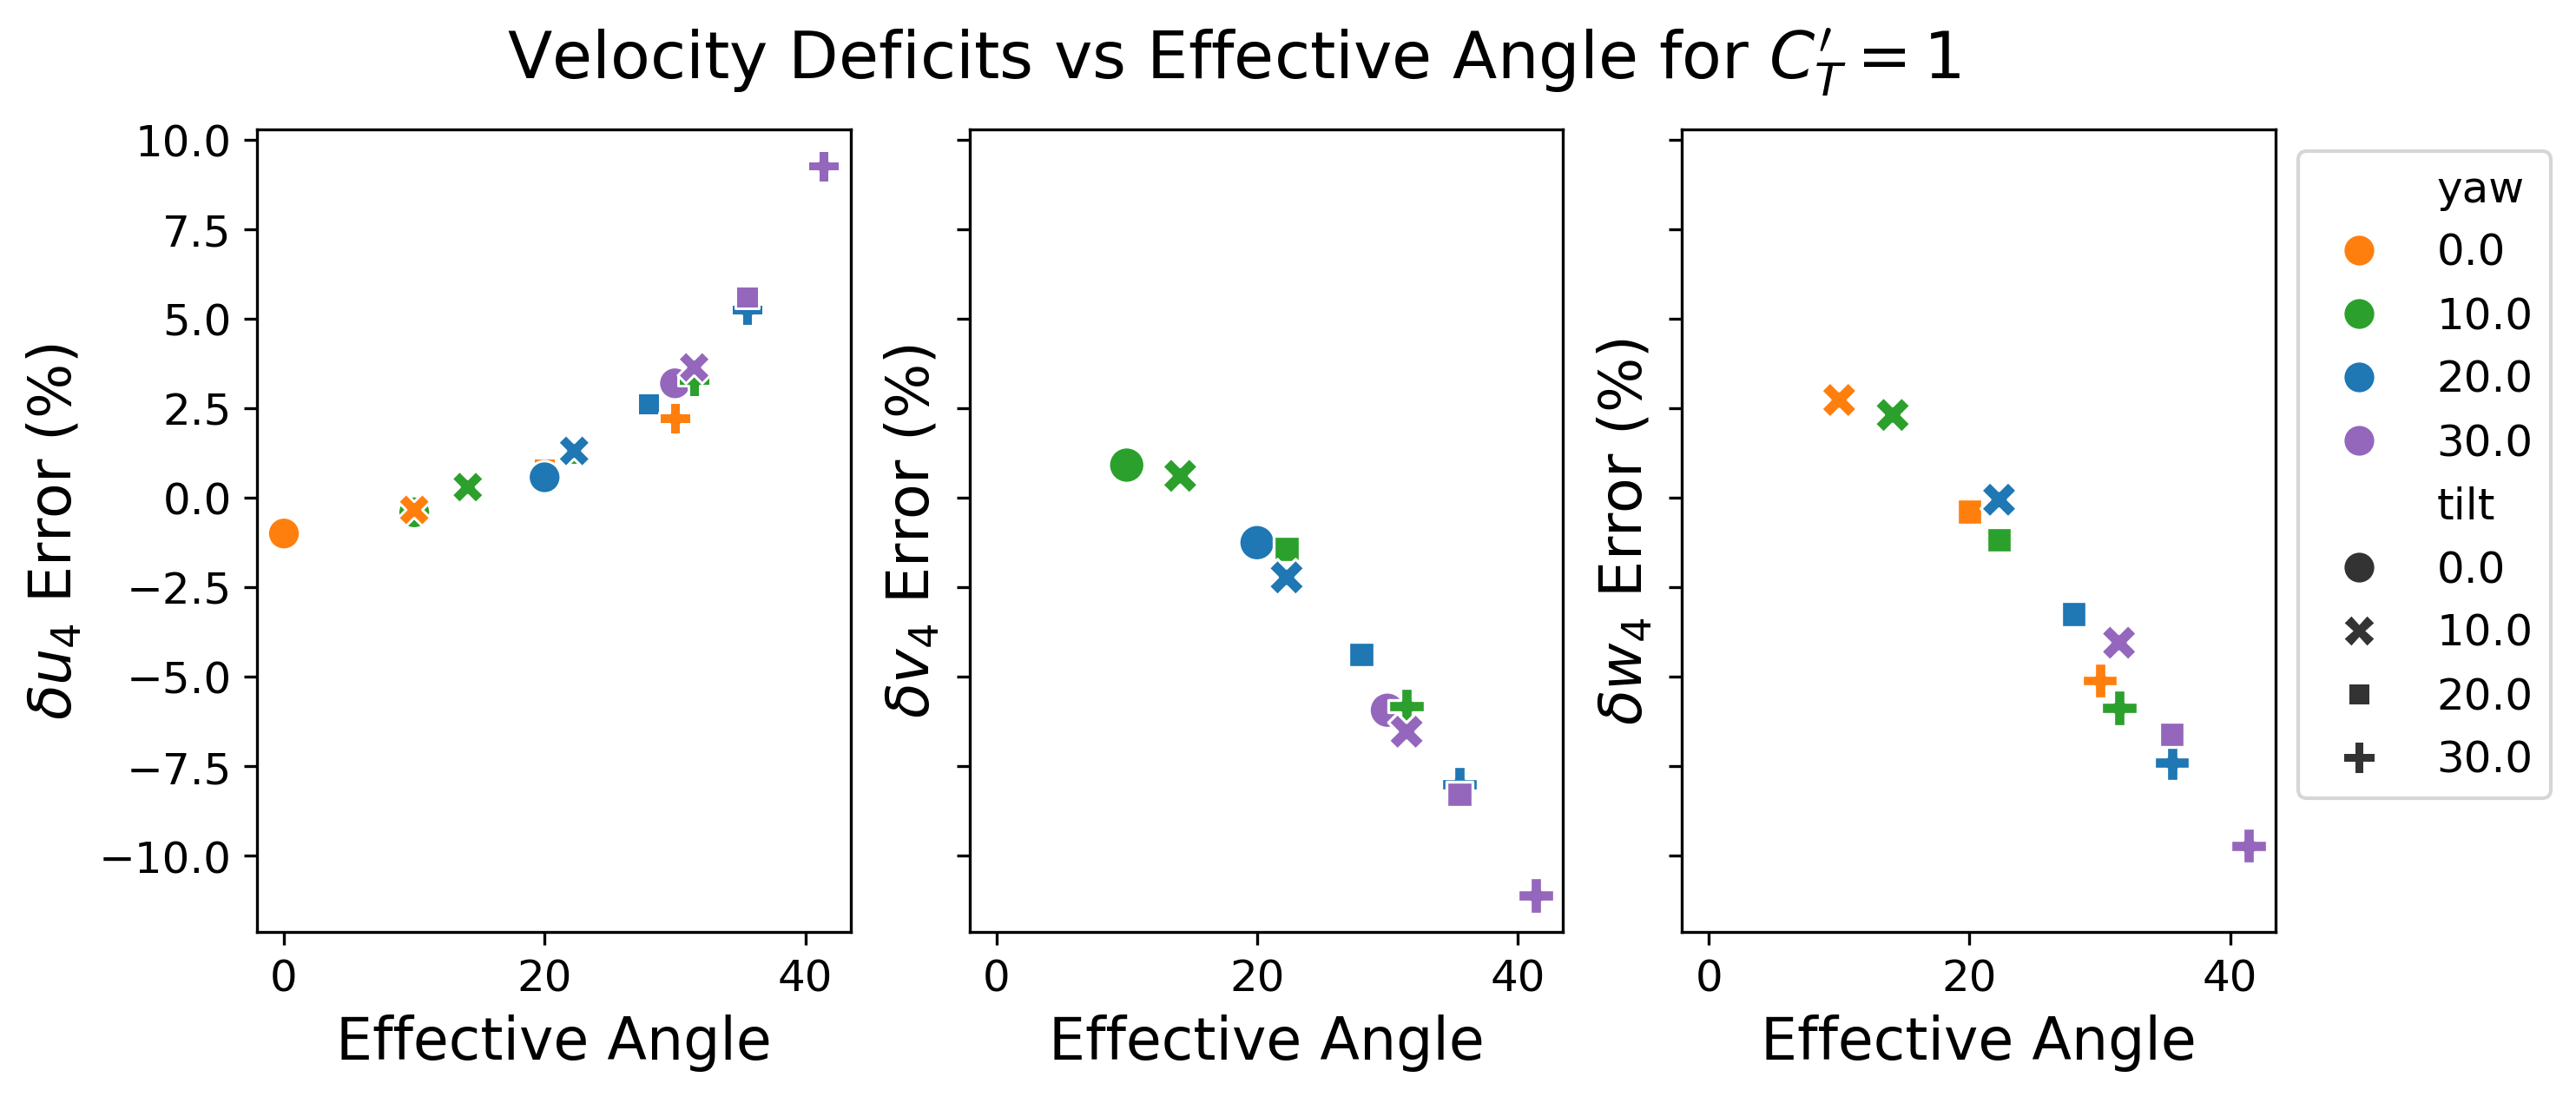

In [65]:
for ctp in [1, 1.33, 4]:
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey = True, sharex = True, figsize = (10, 4), dpi = 300)
    fig.suptitle("Velocity Deficits vs Effective Angle for $C_T' = 1$", size = 18)

    ax0.set_ylabel("$\delta u_4$ Error (%)", size = 16)
    ax1.set_ylabel("$\delta v_4$ Error (%)", size = 16)
    ax2.set_ylabel("$\delta w_4$ Error (%)", size = 16)

    ax0.set_xlabel('Effective Angle', size = 16)
    ax1.set_xlabel('Effective Angle', size = 16)
    ax2.set_xlabel('Effective Angle', size = 16)

    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    sns.scatterplot(ax = ax0, data = compare_umm_df, x="angle", y="du4_err", hue="yaw", style = "tilt", palette = palette, s = 80)
    sns.scatterplot(ax = ax1, data = compare_umm_df, x="angle", y="dv4_err", hue="yaw", style = "tilt", palette = palette, legend = False, s = 100)
    sns.scatterplot(ax = ax2, data = compare_umm_df, x="angle", y="dw4_err", hue="yaw", style = "tilt", palette = palette, legend = False, s = 100)
    leg = ax0.legend(title_fontsize=14, fontsize=12)
    bb = leg.get_bbox_to_anchor().transformed(ax0.transAxes.inverted())
    xOffset = 2.9
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg = leg.set_bbox_to_anchor(bb, transform = ax0.transAxes)